In [2]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)
    
def makeROCPlot(pred,true,label="",noSkill=True):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL")
    plt.legend()
    return auc



In [2]:
#importlib.reload(PeakDetective)

In [3]:
resolution = 60
window = 1.0

In [4]:
#covid_plasma
datadir = "D:/PeakDetective/data/covid_plasma/"
ms1ppm = 25.5
peakWidth = (13.8,114.6)
s2n = 13.6
noise = 1
mzDiff = 0.0144
prefilter = 5

In [88]:
#ST000081
datadir = "D:/PeakDetective/data/ST000081/"
ms1ppm = 11.5
peakWidth = (8.5,31.3)
s2n = 6.81
noise = 1
mzDiff = 0.0144
prefilter = 5.4

In [142]:
#ST001882_GT_RP_Positive
datadir = "D:/PeakDetective/data/ST001882_GT_RP_Positive/"
ms1ppm = 11.5
peakWidth = (8.576,30)
s2n = 9.1
noise = 12970
mzDiff = 0.0144
prefilter = 1

In [143]:
rawDataDir = datadir + "tmp/"

In [144]:
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
#det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
#peakList = peakList[["mz","rt"]]
peakList

mz        rt  rt_start    rt_end    QC_01.mzML  \
FT00001   150.112310  0.747457  0.747450  0.756801  1.974936e+06   
FT00002   150.026482  1.749602  1.747698  1.750253  2.826669e+07   
FT00003   150.026490  2.845811  2.845758  2.855271  8.213799e+06   
FT00004   150.062904  1.255499  1.255089  1.266733  3.205281e+05   
FT00005   150.091273  0.845748  0.831618  0.859937  2.072345e+05   
...              ...       ...       ...       ...           ...   
FT32177  1974.536430  8.815316  8.815316  8.815316  1.895676e+04   
FT32178  1979.207415  6.249797  6.239919  6.258969  7.459506e+04   
FT32179  1980.210251  6.249635  6.240197  6.258969  1.857563e+05   
FT32180  1981.211674  6.249549  6.240390  6.249923  1.741973e+05   
FT32181  1982.212953  6.249580  6.240117  6.249923  1.102636e+05   

           QC_02.mzML    QC_03.mzML    QC_04.mzML    QC_05.mzML    QC_06.mzML  \
FT00001  1.858493e+06  1.798871e+06  1.757297e+06  1.773365e+06  1.768485e+06   
FT00002  2.815197e+07  2.841696e+07  2.881003e+07  3.145220e+07  3.074870e+07   
FT00003  9.725321e+06  9.307397e+06  7.713435e+06  8.139520e+06  7.220048e+06   
FT00004  3.206047e+05  2.857381e+05  3.124773e+05  3.306725e+05  3.484202e+05   
FT00005  1.836083e+05  2.224421e+05  1.704847e+05  2.148285e+05  1.860289e+05   
...               ...           ...           ...           ...           ...   
FT32177  0.000000e+00  1.190416e+05  1.293768e+04  7.919847e+04  0.000000e+00   
FT32178  1.379095e+05  1.272461e+05  1.030717e+05  1.344736e+05  1.053646e+05   
FT32179  1.975252e+05  2.361436e+05  2.210434e+05  2.238891e+05  2.395129e+05   
FT32180  1.996532e+05  1.700717e+05  1.492381e+05  2.215041e+05  1.772771e+05   
FT32181  4.369822e+04  1.171374e+05  1.096281e+05  7.411829e+04  1.437213e+05   

           QC_07.mzML  
FT00001  2.304243e+06  
FT00002  3.318160e+07  
FT00003  8.205855e+06  
FT00004  3.416744e+05  
FT00005  2.334494e+05  
...               ...  
FT32177  2.039624e+05  
FT32178  7.916662e+04  
FT32179  2.108537e+05  
FT32180  2.104139e+05  
FT32181  1.249721e+05  

[32181 rows x 11 columns]

In [145]:
neatMSPeakList = pd.read_csv(datadir + "xcms_peak_list.csv",sep="\t",index_col=0)
neatMSPeakList["feature_id"] = neatMSPeakList.index.values
neatMSPeakList["feature_id2"] = neatMSPeakList.index.values
neatMSPeakList = neatMSPeakList.melt(id_vars = ["mzmed","rtmed","rtmin","rtmax","feature_id"],
                    value_vars = [x for x in neatMSPeakList.columns.values if ".mzML" in x],
                   var_name="sample", value_name="into")
neatMSPeakList["mzmin"] = neatMSPeakList["mzmed"].values - (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["mzmax"] = neatMSPeakList["mzmed"].values + (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["intb"] = neatMSPeakList["into"].values
neatMSPeakList["maxo"] = neatMSPeakList["into"].values
neatMSPeakList["sn"] = [10 for _ in range(len(neatMSPeakList))]
neatMSPeakList["sample_name"] = neatMSPeakList["sample"].values
neatMSPeakList["rtmin"] = neatMSPeakList["rtmin"].values - .2 * 60
neatMSPeakList["rtmax"] = neatMSPeakList["rtmin"].values + .2 * 60
neatMSPeakList = neatMSPeakList.rename({"mzmed":"mz","rtmed":"rt"},axis=1)

neatMSPeakList.to_csv(datadir + "neatms_peak_list.csv",index=False)
neatMSPeakList


mz          rt       rtmin       rtmax feature_id  \
0        150.112310   44.847397   32.847004   44.847004    FT00001   
1        150.026482  104.976143   92.861908  104.861908    FT00002   
2        150.026490  170.748657  158.745468  170.745468    FT00003   
3        150.062904   75.329934   63.305313   75.305313    FT00004   
4        150.091273   50.744864   37.897064   49.897064    FT00005   
...             ...         ...         ...         ...        ...   
225262  1974.536430  528.918945  516.918945  528.918945    FT32177   
225263  1979.207415  374.987793  362.395142  374.395142    FT32178   
225264  1980.210251  374.978076  362.411835  374.411835    FT32179   
225265  1981.211674  374.972961  362.423401  374.423401    FT32180   
225266  1982.212953  374.974823  362.407043  374.407043    FT32181   

            sample          into        mzmin        mzmax          intb  \
0       QC_01.mzML  1.974936e+06   150.110584   150.114036  1.974936e+06   
1       QC_01.mzML  2.826669e+07   150.024757   150.028207  2.826669e+07   
2       QC_01.mzML  8.213799e+06   150.024765   150.028215  8.213799e+06   
3       QC_01.mzML  3.205281e+05   150.061178   150.064630  3.205281e+05   
4       QC_01.mzML  2.072345e+05   150.089547   150.092999  2.072345e+05   
...            ...           ...          ...          ...           ...   
225262  QC_07.mzML  2.039624e+05  1974.513723  1974.559137  2.039624e+05   
225263  QC_07.mzML  7.916662e+04  1979.184654  1979.230176  7.916662e+04   
225264  QC_07.mzML  2.108537e+05  1980.187479  1980.233024  2.108537e+05   
225265  QC_07.mzML  2.104139e+05  1981.188890  1981.234458  2.104139e+05   
225266  QC_07.mzML  1.249721e+05  1982.190158  1982.235748  1.249721e+05   

                maxo  sn sample_name  
0       1.974936e+06  10  QC_01.mzML  
1       2.826669e+07  10  QC_01.mzML  
2       8.213799e+06  10  QC_01.mzML  
3       3.205281e+05  10  QC_01.mzML  
4       2.072345e+05  10  QC_01.mzML  
...              ...  ..         ...  
225262  2.039624e+05  10  QC_07.mzML  
225263  7.916662e+04  10  QC_07.mzML  
225264  2.108537e+05  10  QC_07.mzML  
225265  2.104139e+05  10  QC_07.mzML  
225266  1.249721e+05  10  QC_07.mzML  

[225267 rows x 13 columns]

In [146]:
feature_table_path = datadir+"neatms_peak_list.csv"
input_data = 'xcms'
experiment = ntms.Experiment(rawDataDir, feature_table_path, input_data)

In [147]:
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)

In [148]:
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)
nn_handler.get_model_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 120, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 120, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 60, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 60, 64)         18496     
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               983168    
                                                           

In [149]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
993/993 [==============================] - 23s 23ms/step
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
992/992 [==============================] - 27s 27ms/step
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
992/992 [==============================] - 28s 28ms/step
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
992/992 [==============================] - 46s 46ms/step
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
992/992 [==============================] - 58s 58ms/step
[Warning] Not index found and build_index_from_scratch is False
[Warning] N

In [150]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

feature ID sample          m/z  retention time        height  \
0             6022  QC_01   150.112310        0.747457  1.974936e+06   
1             6022  QC_02   150.112310        0.747457  1.858493e+06   
2             6022  QC_03   150.112310        0.747457  1.798871e+06   
3             6022  QC_04   150.112310        0.747457  1.757297e+06   
4             6022  QC_05   150.112310        0.747457  1.773365e+06   
...            ...    ...          ...             ...           ...   
222235       38202  QC_03  1982.212953        6.249580  1.171374e+05   
222236       38202  QC_04  1982.212953        6.249580  1.096281e+05   
222237       38202  QC_05  1982.212953        6.249580  7.411829e+04   
222238       38202  QC_06  1982.212953        6.249580  1.437213e+05   
222239       38202  QC_07  1982.212953        6.249580  1.249721e+05   

                area         label  
0       1.974936e+06  High_quality  
1       1.858493e+06         Noise  
2       1.798871e+06  High_quality  
3       1.757297e+06  High_quality  
4       1.773365e+06  High_quality  
...              ...           ...  
222235  1.171374e+05  High_quality  
222236  1.096281e+05  High_quality  
222237  7.411829e+04  High_quality  
222238  1.437213e+05  High_quality  
222239  1.249721e+05  High_quality  

[222240 rows x 7 columns]

In [151]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['QC_01.mzML', 'QC_02.mzML', 'QC_03.mzML', 'QC_04.mzML', 'QC_05.mzML', 'QC_06.mzML', 'QC_07.mzML']


In [152]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

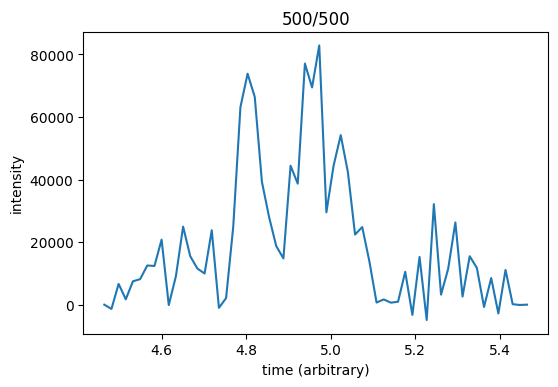

Enter classification (1=True Peak, 0=Artifact): 


 0


In [81]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)
    peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [153]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [154]:
#if __name__ == "__main__":
#    rts = peakList["rt"].values
#    X_unaligned = integ.makeDataMatrix(raw_data,peakList["mz"],rts,align=False)

In [155]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data,peakList["mz"],rts,align=True)

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 


In [156]:
if __name__ == "__main__":
    rts = peakList_labeled["rt"].values
    X_labeled = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],peakList_labeled["rt"],align=False)
    y_labeled = peakList_labeled["classification"].values
    y_labeled = np.array([[-1*y + 1,y] for y in y_labeled])

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [157]:
X_signal = integ.generateSignalPeaks(peakList,raw_data,n=50)
X_noise = integ.generateFalsePeaks(peakList,raw_data,n=50)
X_syn = np.concatenate((X_signal,X_noise),axis=0)
y_syn = np.array([[0.0,1.0] for _ in X_signal] + [[1.0,0.0] for _ in X_noise])

forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


In [158]:
pkl.dump([X,X_labeled,y_labeled,X_syn,y_syn],open(datadir + "model_selection_data.pkl","wb"))

In [159]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open(datadir + "model_selection_data.pkl","rb"))

In [42]:
# if __name__ == "__main__":
#     X_unaligned = integ.makeDataMatrix(raw_data,peakList_labeled["mz"],peakList_labeled["rt"],align=False)
#     X_aligned = integ.makeDataMatrix(raw_data,peakList_labeled["mz"],peakList_labeled["rt"],align=True)

In [43]:
# plt.scatter(X_unaligned.flatten(),X_aligned.flatten(),s=3,c="black")

In [44]:
# i = rd.choice(list(range(len(peakList_labeled))))
# for x in range(len(raw_data)):
#     plt.plot(X_unaligned[x*len(peakList_labeled) + i])
# plt.figure()
# for x in range(len(raw_data)):
#     plt.plot(X_aligned[x*len(peakList_labeled) + i])


In [24]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,10,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/10
1407/1407 [==============================] - 25s 17ms/step - loss: 0.1337 - mean_absolute_error: 0.0580 - val_loss: 0.0826 - val_mean_absolute_error: 0.0158
Epoch 2/10
1407/1407 [==============================] - 23s 17ms/step - loss: 0.0770 - mean_absolute_error: 0.0132 - val_loss: 0.0732 - val_mean_absolute_error: 0.0102
Epoch 3/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.0721 - mean_absolute_error: 0.0096 - val_loss: 0.0716 - val_mean_absolute_error: 0.0088
Epoch 4/10
1407/1407 [==============================] - 23s 16ms/step - loss: 0.0709 - mean_absolute_error: 0.0087 - val_loss: 0.0707 - val_mean_absolute_error: 0.0081
Epoch 5/10
1407/1407 [==============================] - 23s 16ms/step - loss: 0.0702 - mean_absolute_error: 0.0081 - val_loss: 0.0701 - val_mean_absolute_error: 0.0076
Epoch 6/10
1407/1407 [==================

In [25]:
integ.save(datadir + "smoothed_only/")

In [160]:
integ.load(datadir + "smoothed_only/")

In [161]:
valInds = list(range(len(X_labeled)))
valInds = rd.sample(valInds,k=250)
testInds = rd.sample(valInds,k=200)
valInds = [x for x in valInds if x not in testInds]

X_val = X_labeled[valInds]
y_val = y_labeled[valInds]

X_test = X_labeled[testInds]
y_test = y_labeled[testInds]

X_labeled = X_labeled[[x for x in range(len(X_labeled)) if x not in valInds + testInds]]
y_labeled = y_labeled[[x for x in range(len(y_labeled)) if x not in valInds + testInds]]

In [162]:
peaks_test = peakList_labeled.iloc[testInds,:].reset_index()
peaks_test

index           mz         rt   rt_start     rt_end    QC_01.mzML  \
0    FT20396   877.653495   6.707921   6.698509   6.736136  2.878609e+06   
1    FT02452   317.246979   8.185889   8.176555   8.195195  2.184866e+06   
2    FT08295   564.469520   3.360673   3.351322   3.360699  1.783160e+06   
3    FT22552   926.800040  10.129735  10.129735  10.129735  3.364142e+04   
4    FT12635   683.532349   4.959489   4.908057   4.968937  2.818279e+05   
..       ...          ...        ...        ...        ...           ...   
195  FT29229  1293.383004   7.077825   7.073116   7.082534  3.600352e+05   
196  FT27416  1120.884235   6.726702   6.651189   6.726775  5.156854e+05   
197  FT24308   973.643266   5.543424   5.533772   5.543651  2.389361e+05   
198  FT18184   825.655308   4.633701   4.633701   4.633701  7.234169e+04   
199  FT22933   936.802908  11.765473  11.757081  11.773865  5.155717e+04   

       QC_02.mzML    QC_03.mzML    QC_04.mzML    QC_05.mzML    QC_06.mzML  \
0    2.738013e+06  2.876068e+06  2.862735e+06  2.943410e+06  2.880685e+06   
1    2.731185e+06  2.399821e+06  2.305088e+06  2.451684e+06  2.300547e+06   
2    1.772884e+06  1.727845e+06  1.676923e+06  1.500491e+06  1.858531e+06   
3    5.603740e+03  5.553747e+04  0.000000e+00  1.524891e+04  1.578515e+04   
4    3.099355e+05  8.539303e+04  8.954209e+04  1.270398e+05  1.053572e+06   
..            ...           ...           ...           ...           ...   
195  2.190004e+05  2.914681e+05  8.847753e+04  3.397609e+05  1.590616e+05   
196  4.797247e+05  5.449771e+05  5.318627e+05  5.632619e+05  6.072499e+05   
197  1.968149e+05  2.130302e+05  7.926959e+04  2.730204e+05  2.334514e+05   
198  8.978570e+04  8.162570e+04  1.041014e+05  1.178617e+05  9.887497e+04   
199  8.875713e+04  6.707649e+04  8.122002e+04  4.117313e+04  5.392891e+04   

       QC_07.mzML  classification  
0    5.138490e+06             1.0  
1    2.831589e+06             1.0  
2    2.117627e+06             1.0  
3    1.686955e+04             1.0  
4    1.531016e+05             1.0  
..            ...             ...  
195  2.693232e+05             1.0  
196  6.155213e+05             1.0  
197  2.209393e+05             0.0  
198  9.532961e+04             0.0  
199  4.856767e+04             1.0  

[200 rows x 13 columns]

In [163]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

feature ID sample          m/z  retention time        height  \
0             6022  QC_01   150.112310        0.747457  1.974936e+06   
7             6023  QC_01   150.026482        1.749602  2.826669e+07   
14            6024  QC_01   150.026490        2.845811  8.213799e+06   
21            6025  QC_01   150.062904        1.255499  3.205281e+05   
28            6026  QC_01   150.091273        0.845748  2.072345e+05   
...            ...    ...          ...             ...           ...   
222205       38198  QC_01  1974.536430        8.815316  1.895676e+04   
222212       38199  QC_01  1979.207415        6.249797  7.459506e+04   
222219       38200  QC_01  1980.210251        6.249635  1.857563e+05   
222226       38201  QC_01  1981.211674        6.249549  1.741973e+05   
222233       38202  QC_01  1982.212953        6.249580  1.102636e+05   

                area         label  
0       1.974936e+06  High_quality  
7       2.826669e+07         Noise  
14      8.213799e+06         Noise  
21      3.205281e+05         Noise  
28      2.072345e+05         Noise  
...              ...           ...  
222205  1.895676e+04  High_quality  
222212  7.459506e+04  High_quality  
222219  1.857563e+05  High_quality  
222226  1.741973e+05  High_quality  
222233  1.102636e+05  High_quality  

[31769 rows x 7 columns]

In [164]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

84


In [165]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

feature ID sample          m/z  retention time        height  \
16564         8473  QC_01   317.246979        8.185889  2.184866e+06   
132251       25231  QC_01   849.631864        6.411834  8.286492e+04   
175333       31456  QC_01  1011.985697       10.647423  5.456127e+04   
49186        13209  QC_01   526.574738        5.035324  8.209250e+05   
607           6110  QC_01   159.116535        2.911193  1.032033e+07   
...            ...    ...          ...             ...           ...   
94635        19809  QC_01   712.520061        2.334885  2.316123e+05   
213922       37005  QC_01  1603.385199        8.438802  2.038930e+06   
201735       35250  QC_01  1293.383004        7.077825  3.600352e+05   
189122       33437  QC_01  1120.884235        6.726702  5.156854e+05   
167517       30329  QC_01   973.643266        5.543424  2.389361e+05   

                area         label  classification  
16564   2.184866e+06         Noise             0.0  
132251  8.286492e+04         Noise             0.0  
175333  5.456127e+04         Noise             0.0  
49186   8.209250e+05         Noise             0.0  
607     1.032033e+07         Noise             0.0  
...              ...           ...             ...  
94635   2.316123e+05  High_quality             1.0  
213922  2.038930e+06  High_quality             1.0  
201735  3.600352e+05  High_quality             1.0  
189122  5.156854e+05  High_quality             1.0  
167517  2.389361e+05         Noise             0.0  

[84 rows x 8 columns]

In [166]:
X_labeled_norm = PeakDetective.normalizeMatrix(X_labeled)
X_labeled_smoothed = integ.smoother.predict(PeakDetective.normalizeMatrix(X_labeled))

8/8 [==============================] - 0s 31ms/step


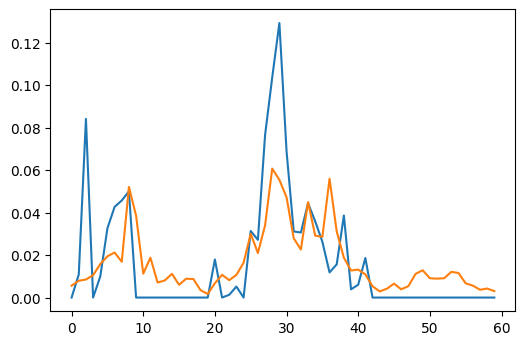

In [167]:
ind = rd.choice(list(range(len(X_labeled))))
plt.plot(X_labeled_norm[ind])
plt.plot(X_labeled_smoothed[ind])

In [168]:
X_test = X_test[order]
y_test = y_test[order]

In [169]:
y_test_scores_neat_ms = filt["classification"].values

In [113]:
if __name__ == "__main__":
    integ.trainClassifier(X_labeled,y_labeled,X_val,y_val,200,1000,32,5)

2/2 [==============================] - 0s 5ms/step
loss: 0.38248342275619507 mean_absolute_error: 0.20891401171684265 val loss: 0.37457096576690674 val_mean_absolute_error: 0.20952865481376648 numEpochs: 557


In [37]:
integ.save(datadir + "supervised/")

In [170]:
integ.load(datadir + "supervised/")

In [171]:
y_test_scores_supervised = integ.classifyMatrix(X_test)

3/3 [==============================] - 0s 4ms/step


In [103]:
# if __name__ == "__main__":
#     integ.trainClassifier(X_syn,y_syn,X_val,y_val,1000,32,5)

In [104]:
# y_test_scores_syn = integ.classifyMatrix(X_test)

1/1 [==============================] - 0s 38ms/step
loss: 0.37267637252807617 mean_absolute_error: 0.13923323154449463 val loss: 0.3778761923313141 val_mean_absolute_error: 0.1444634646177292 numEpochs: 225
7039/7039 [==============================] - 11s 2ms/step


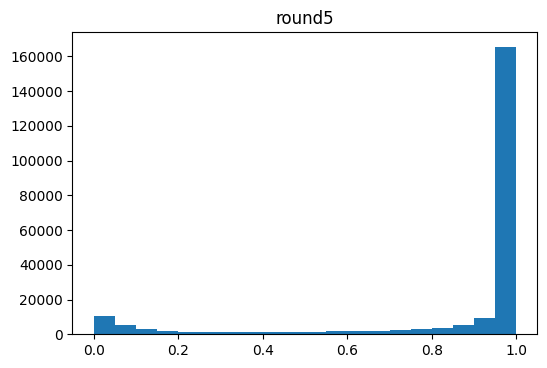

225232 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


In [105]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,X_syn,y_syn,200,1000,32,5,numVal = 10,numManualPerRound=5,inJupyter=True)

In [106]:
integ.save(datadir + "active/")

In [172]:
integ.load(datadir + "active/")

In [173]:
y_test_scores_active_syn = integ.classifyMatrix(X_test)

3/3 [==============================] - 0s 3ms/step


In [174]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=0.5,align=False)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
7040/7040 [==============================] - 10s 1ms/step


In [175]:
predInt = []
file = files[0]
for index,row in peaks_test.loc[order,:].iterrows():
    predInt.append(peak_intensities.at[row["index"],datadir+file])


In [176]:
predCV = []
trueCV = []
for index,row in peaks_test.loc[order,:].iterrows():
    ints = [peak_intensities.at[row["index"],datadir+file] for file in files]
    cv = 1 - np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0 and cv < 1:
        predCV.append(cv)
        trueCV.append(row["classification"])

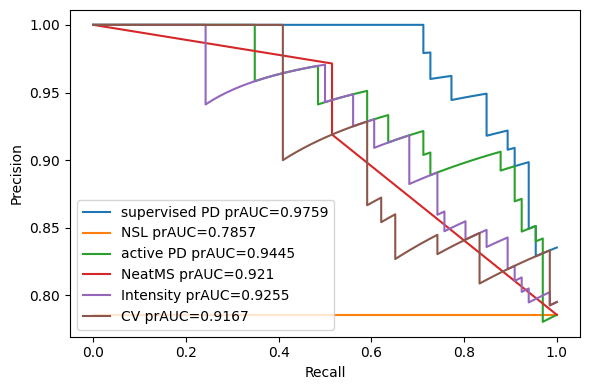

In [177]:
makePRCPlot(y_test_scores_supervised[:,1],y_test[:,1],noSkill=True,label="supervised PD")
makePRCPlot(y_test_scores_active_syn[:,1],y_test[:,1],noSkill=False,label="active PD")
makePRCPlot(y_test_scores_neat_ms,y_test[:,1],noSkill=False,label="NeatMS")
makePRCPlot(predInt,y_test[:,1],noSkill=False,label="Intensity")
makePRCPlot(predCV,trueCV,noSkill=False,label="CV")
plt.tight_layout()
plt.savefig(datadir+"PRC.png",dpi=300)

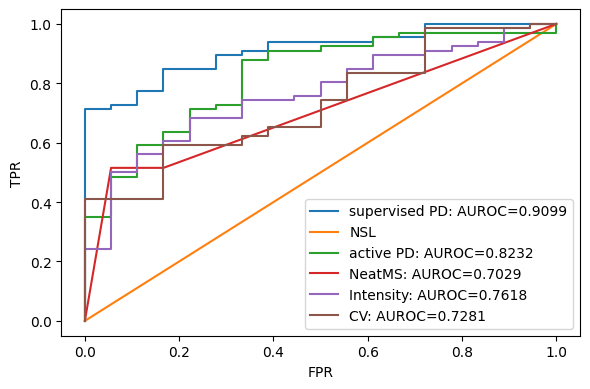

In [178]:
makeROCPlot(y_test_scores_supervised[:,1],y_test[:,1],noSkill=True,label="supervised PD")
makeROCPlot(y_test_scores_active_syn[:,1],y_test[:,1],noSkill=False,label="active PD")
makeROCPlot(y_test_scores_neat_ms,y_test[:,1],noSkill=False,label="NeatMS")
makeROCPlot(predInt,y_test[:,1],noSkill=False,label="Intensity")
makeROCPlot(predCV,trueCV,noSkill=False,label="CV")
plt.tight_layout()
plt.savefig(datadir+"ROC.png",dpi=300)

In [179]:
acc_results = pd.DataFrame.from_dict({"supervised PD":met.accuracy_score(y_test[:,1],y_test_scores_supervised[:,1] > 0.5),
                                     "active PD":met.accuracy_score(y_test[:,1],y_test_scores_active_syn[:,1] > 0.5),
                                     "NeatMS":met.accuracy_score(y_test[:,1],y_test_scores_neat_ms > 0.25)},orient="index")
acc_results.to_csv(datadir + "accuracy_results.csv")

In [199]:
acc_results

0
supervised PD  0.785714
active PD      0.785714
NeatMS         0.583333

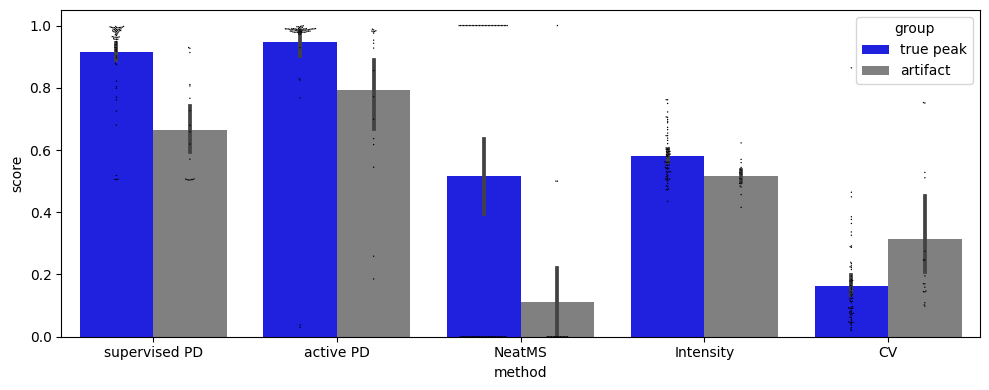

In [180]:
plt_df = {}
for x in range(len(y_test)):
    if y_test[x][1] > 0.5:
        plt_df[len(plt_df)] = {"method":"supervised PD","group":"true peak","score":y_test_scores_supervised[x][1]}
        plt_df[len(plt_df)] = {"method":"active PD","group":"true peak","score":y_test_scores_active_syn[x][1]}
        plt_df[len(plt_df)] = {"method":"NeatMS","group":"true peak","score":y_test_scores_neat_ms[x]}
        plt_df[len(plt_df)] = {"method":"Intensity","group":"true peak","score":np.log10(predInt[x]+2)/10}
    else:
        plt_df[len(plt_df)] = {"method":"supervised PD","group":"artifact","score":y_test_scores_supervised[x][1]}
        plt_df[len(plt_df)] = {"method":"active PD","group":"artifact","score":y_test_scores_active_syn[x][1]}
        plt_df[len(plt_df)] = {"method":"NeatMS","group":"artifact","score":y_test_scores_neat_ms[x]}
        plt_df[len(plt_df)] = {"method":"Intensity","group":"artifact","score":np.log10(predInt[x]+2)/10}
for x in range(len(predCV)):
    if trueCV[x] > 0.5:
        plt_df[len(plt_df)] = {"method":"CV","group":"true peak","score":1-predCV[x]}
    else:
        plt_df[len(plt_df)] = {"method":"CV","group":"artifact","score":1-predCV[x]}

plt_df = pd.DataFrame.from_dict(plt_df,orient="index")
plt.figure(figsize=(10,4))
#sb.violinplot(data=plt_df,x="method",y="score",hue="group",cut=0,palette={"true peak":"blue","artifact":"grey"})
#sb.boxplot(data=plt_df,x="method",y="score",hue="group",fliersize=0,palette={"true peak":"blue","artifact":"grey"})
sb.barplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"blue","artifact":"grey"})
sb.swarmplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"black","artifact":"black"},dodge=True,s=1,legend=False)
plt.tight_layout()
plt.savefig(datadir+"bar.png",dpi=300)

In [181]:
y = integ.classifyMatrix(X)

7040/7040 [==============================] - 11s 2ms/step


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


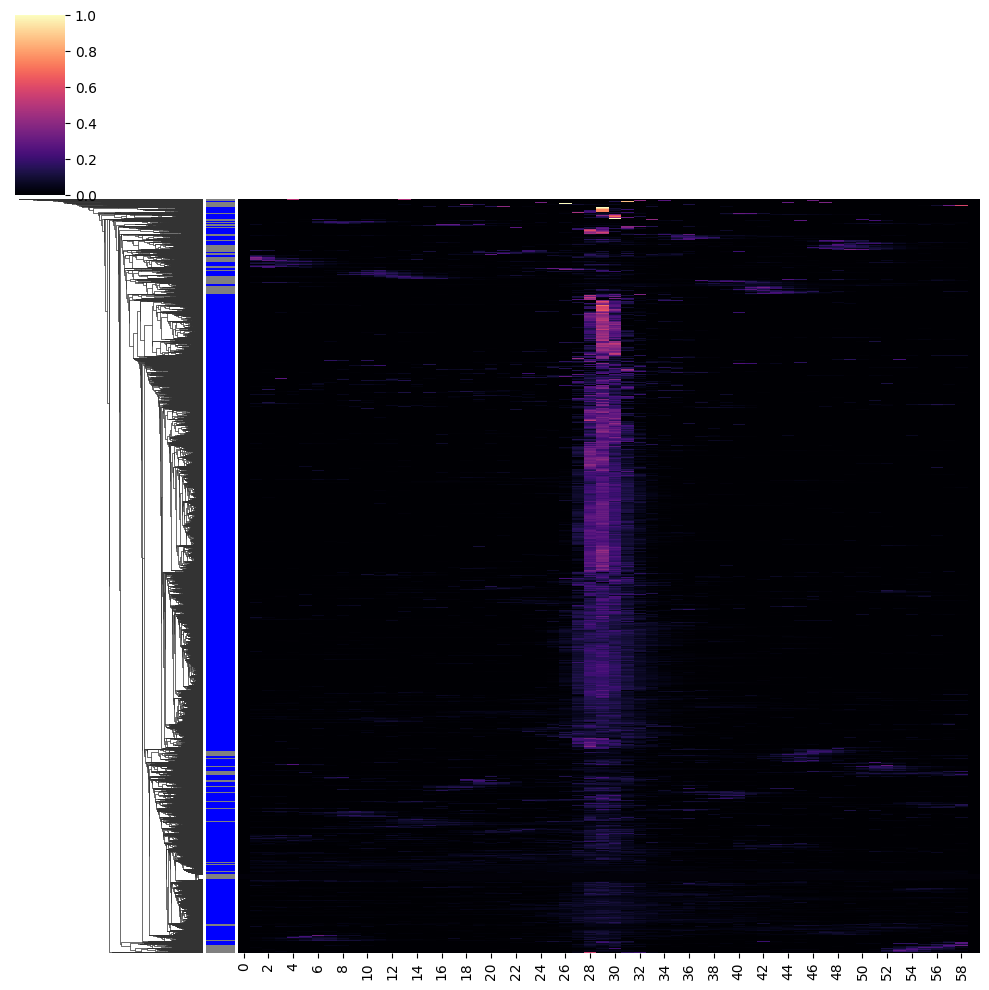

In [182]:
def tmp(val):
    if val > 0.5:
        return "blue"
    return "grey"
row_colors = [tmp(x) for x in y[:len(peakList),1]]
f = sb.clustermap(PeakDetective.normalizeMatrix(X[:len(peakList)]),col_cluster=False,yticklabels=False,cmap="magma",vmin=0.0,vmax=1.0,row_colors=row_colors)
f.savefig(datadir + "heatmap.png",dpi=300)

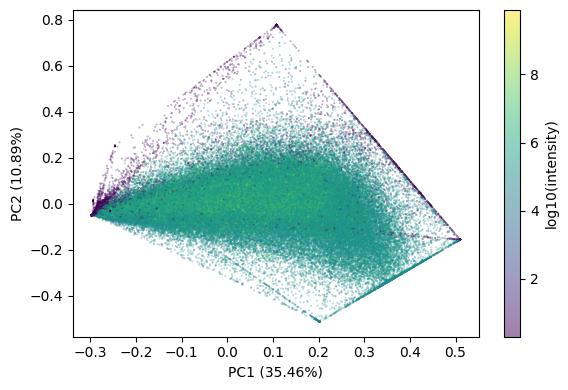

In [183]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))
plt.colorbar(label="log10(intensity)")
plt.tight_layout()
plt.savefig(datadir + "pca_int.png",dpi=300)

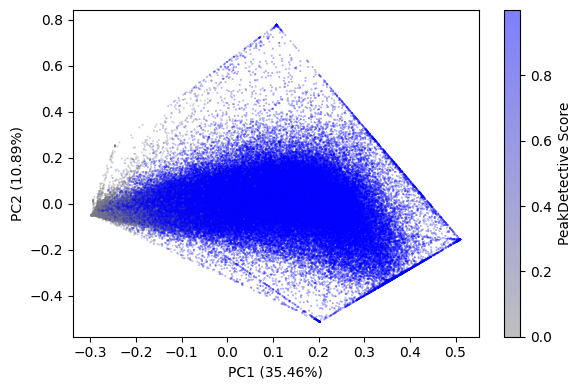

In [184]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))

plt.colorbar(label="PeakDetective Score")
plt.tight_layout()
plt.savefig(datadir + "pca_pd.png",dpi=300)

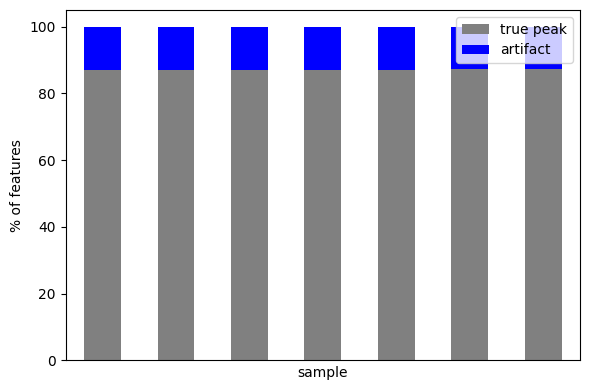

In [185]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > 0.5:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")
plt.tight_layout()
plt.savefig(datadir + "bar_pd_arts.png",dpi=300)

['QC_01.mzML', 'QC_02.mzML', 'QC_03.mzML', 'QC_04.mzML', 'QC_05.mzML', 'QC_06.mzML', 'QC_07.mzML']


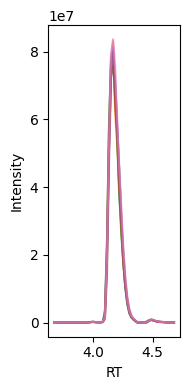

In [186]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,color="black"):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = files[0]
print(files)
inds = list(peak_curated.index.values)
rd.shuffle(inds)
plt.figure(figsize=(2,4))
for i in inds:
    if peak_curated.at[i,datadir + file] > 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break
plt.tight_layout()
plt.savefig(datadir + "true_peak_example.png",dpi=300)


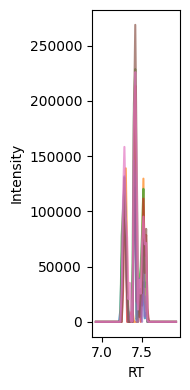

In [196]:
rd.shuffle(inds)
plt.figure(figsize=(2,4))
for i in inds:
    if peak_curated.at[i,datadir + file] < 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break
plt.tight_layout()
plt.savefig(datadir + "artifact_example.png",dpi=300)

In [197]:
true = []
pred = []
file = files[0]
fps = []
fns = []
for index,row in peakList_labeled.iterrows():
    if peak_curated.at[index,datadir + file] > 0.5:
        pred.append(1.0)
        if row["classification"] < 0.5:
            fps.append(index)
    else:
        pred.append(0.0)
        if row["classification"] > .5:
            fns.append(index)
    true.append(row["classification"])
    
confusion_matrix(true,pred)

array([[ 30, 113],
       [ 21, 336]], dtype=int64)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


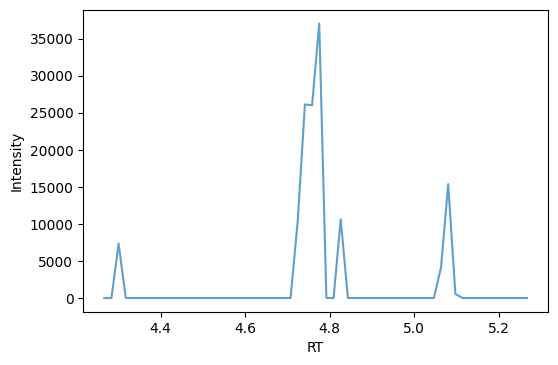

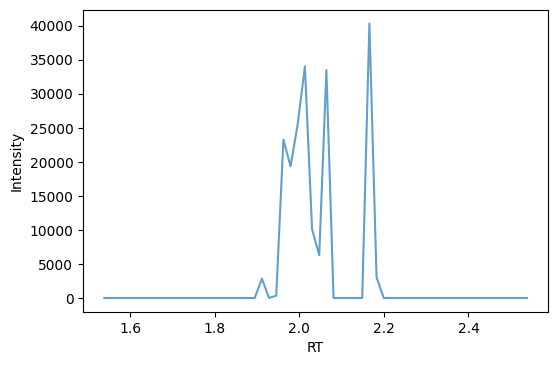

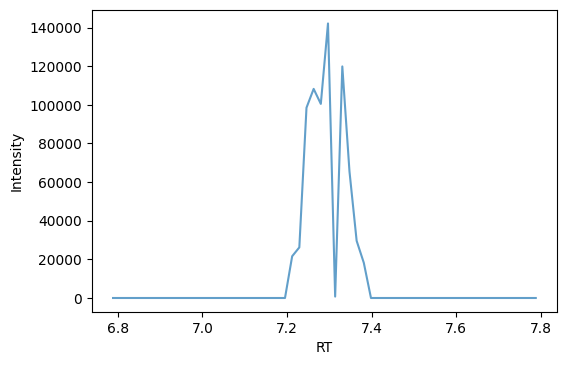

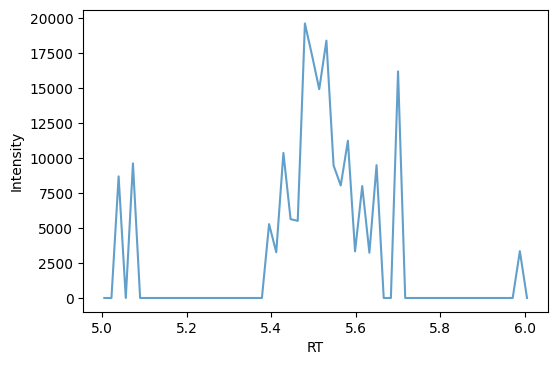

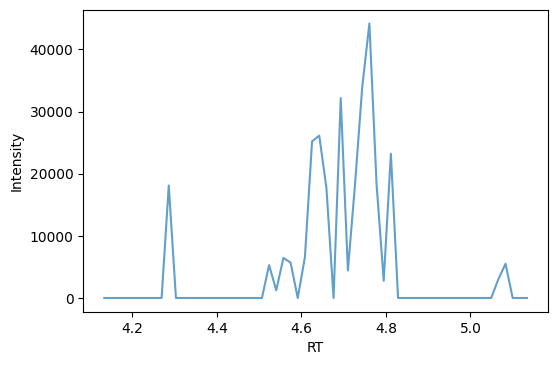

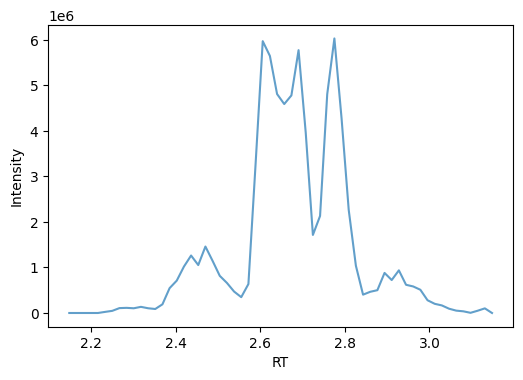

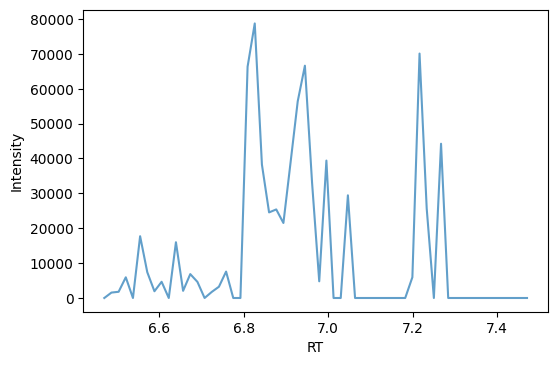

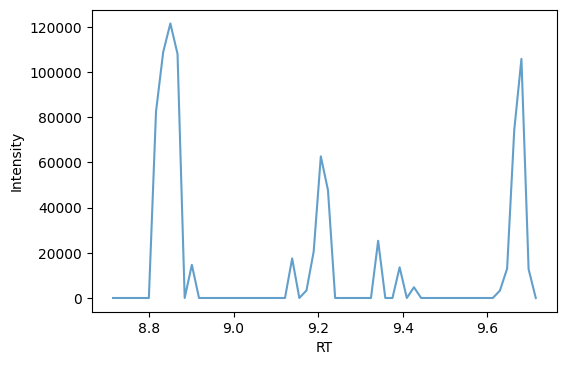

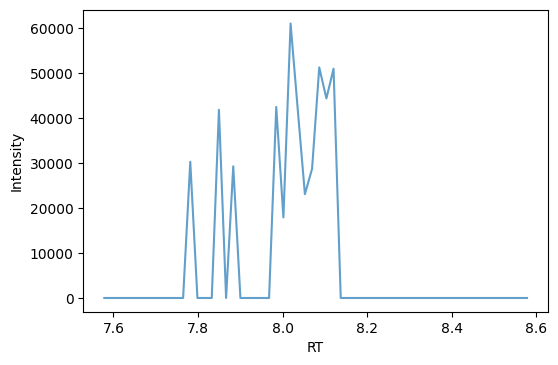

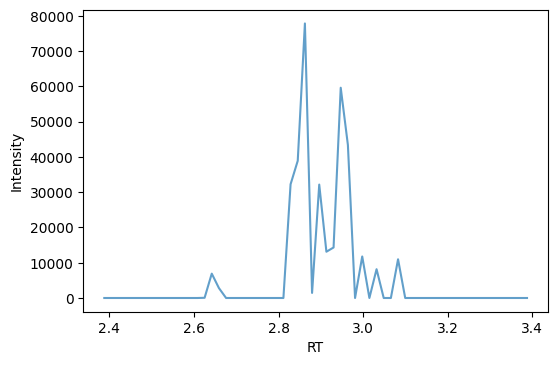

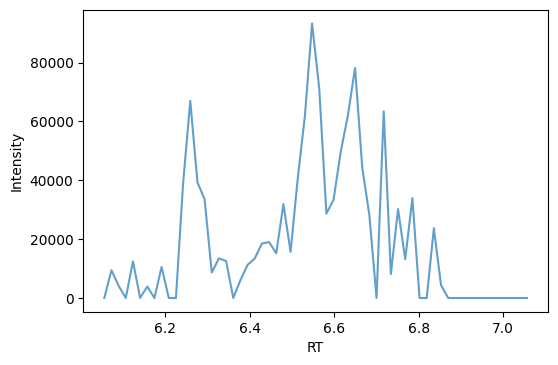

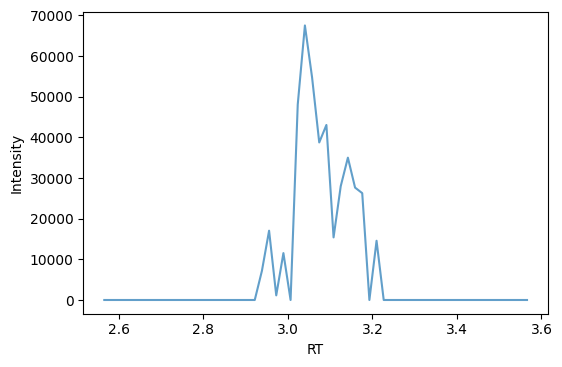

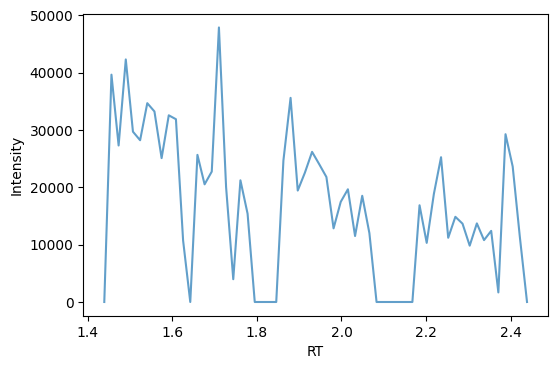

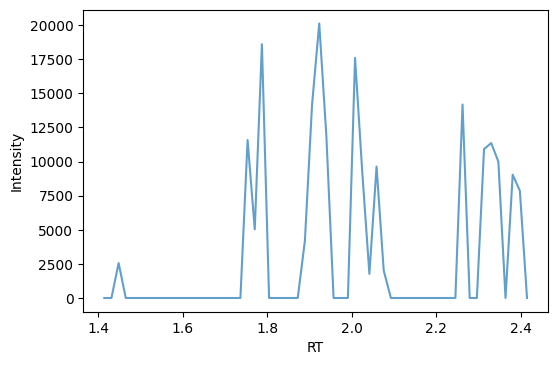

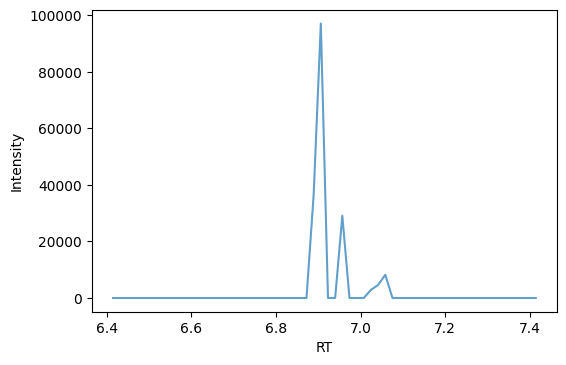

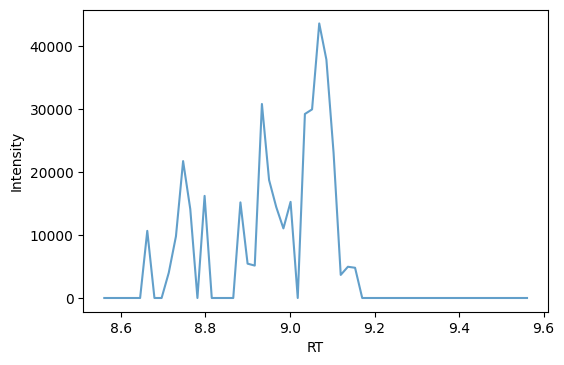

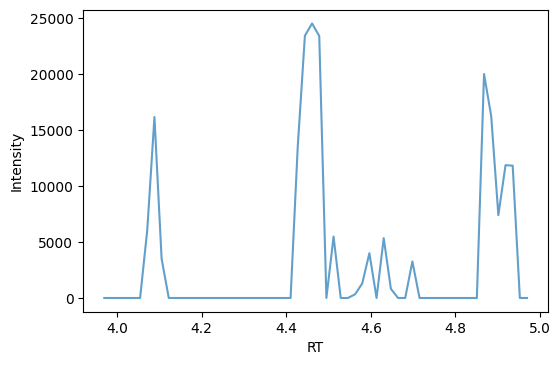

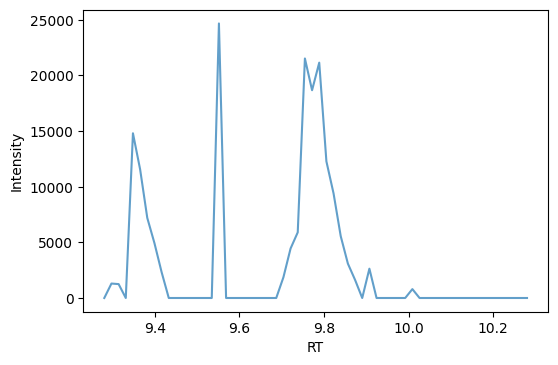

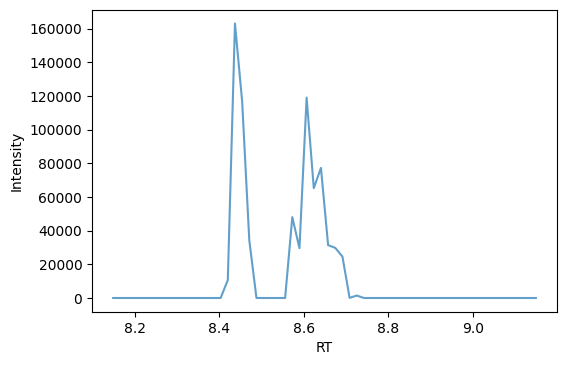

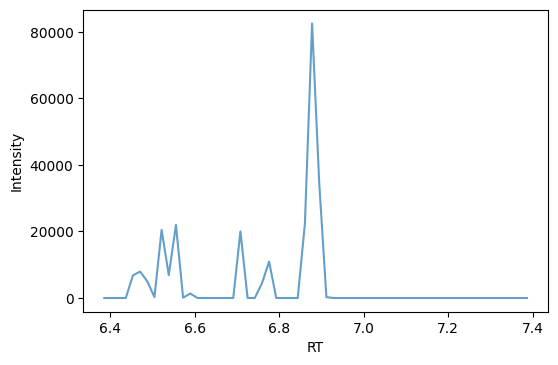

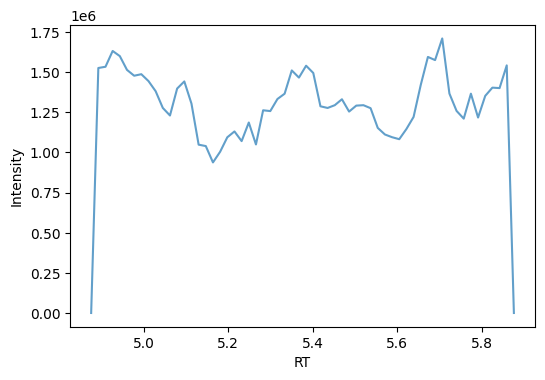

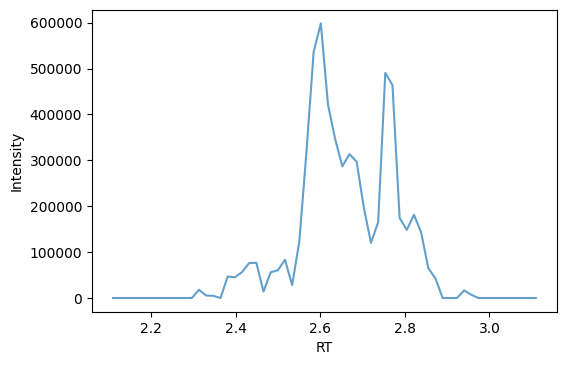

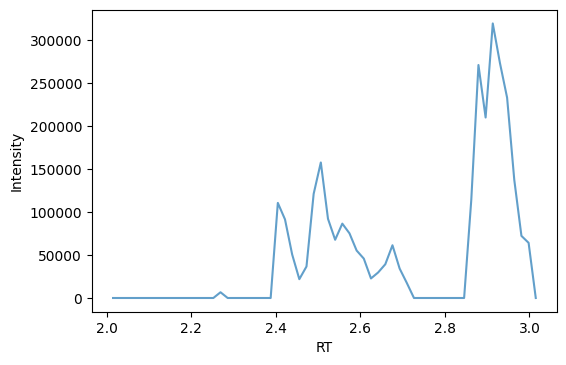

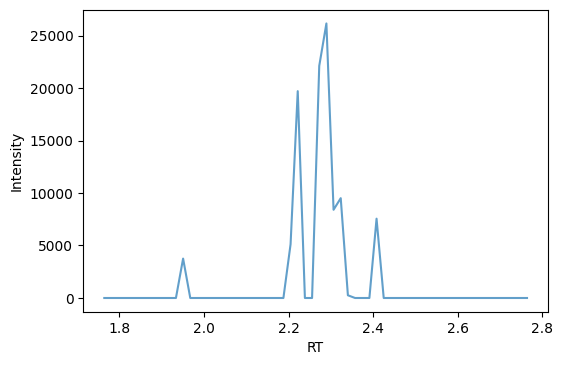

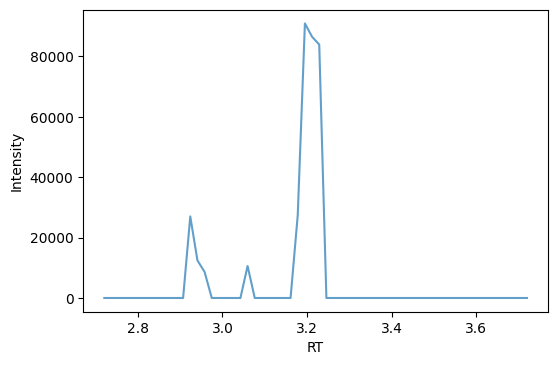

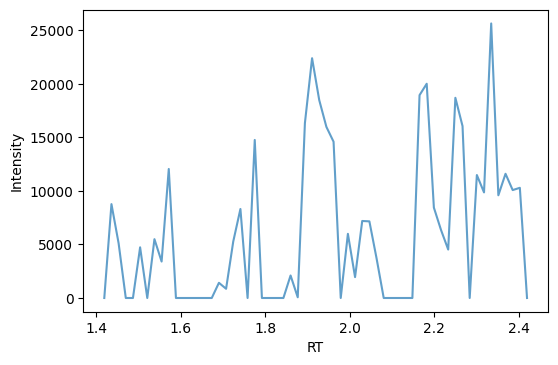

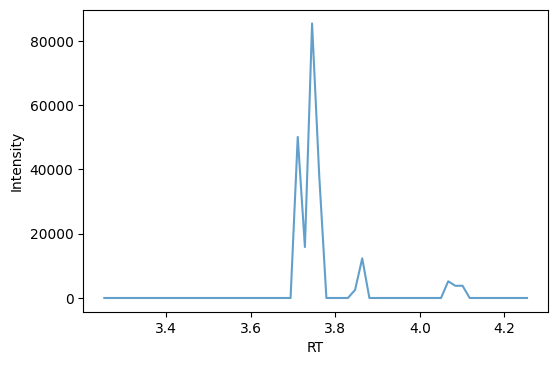

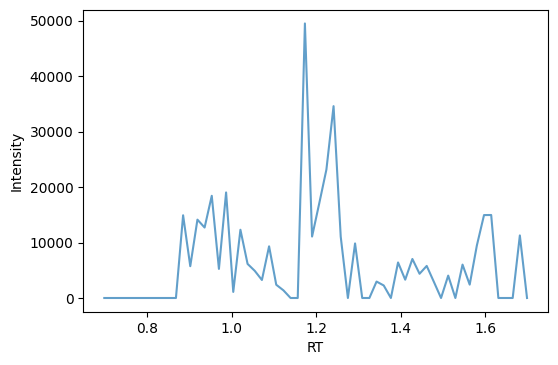

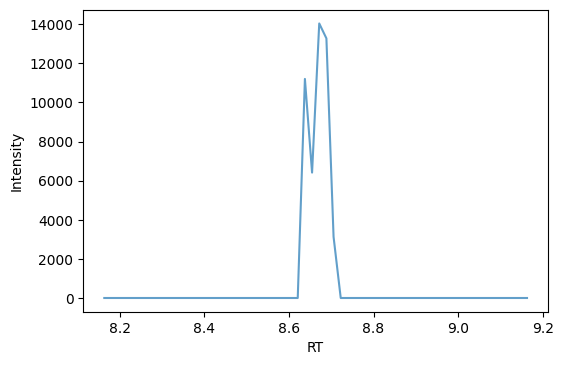

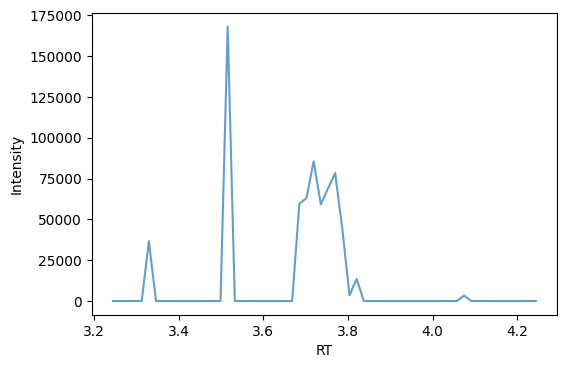

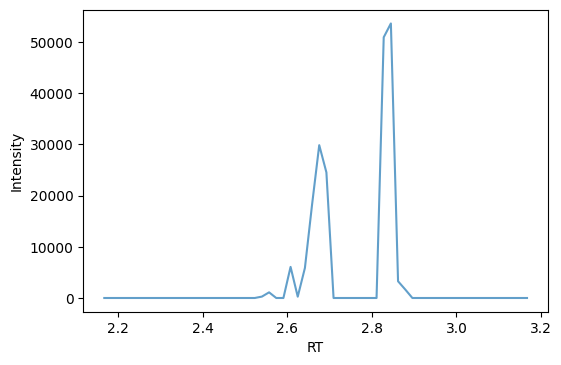

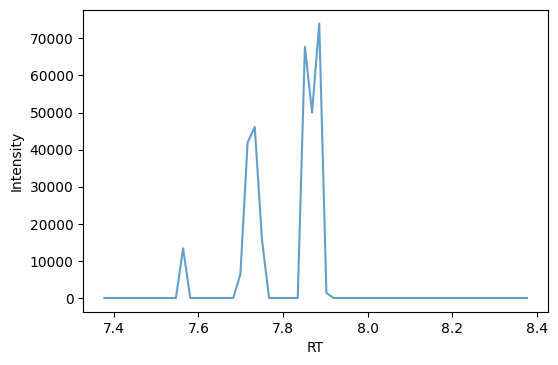

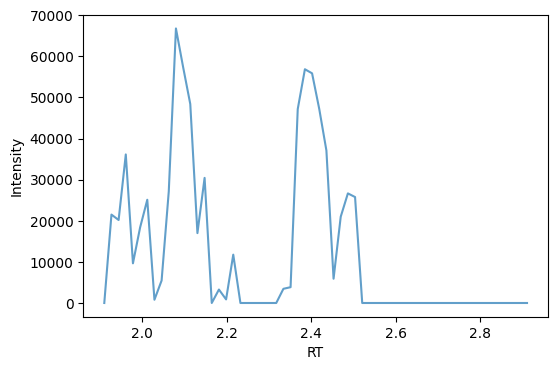

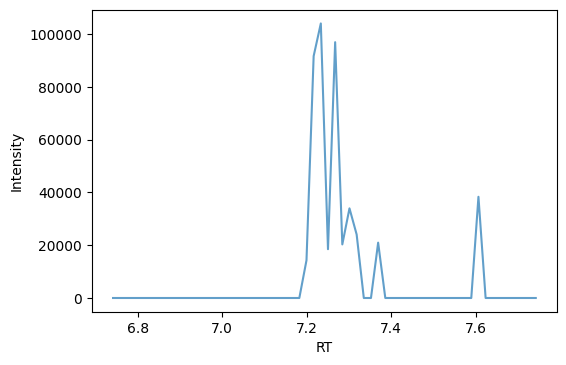

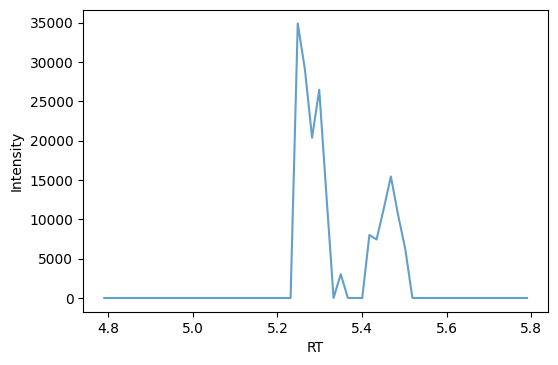

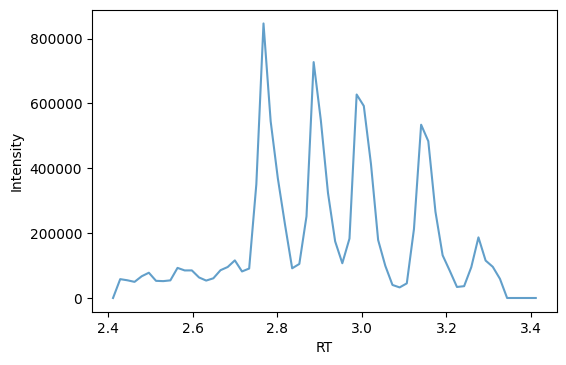

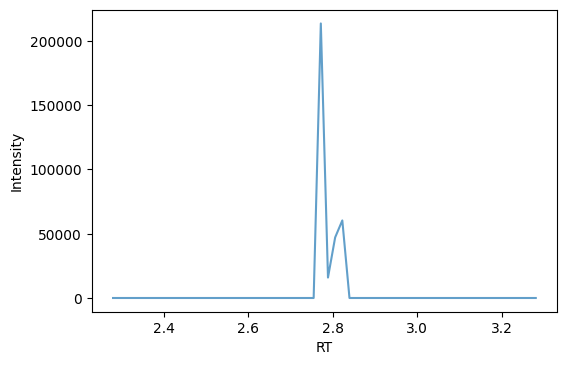

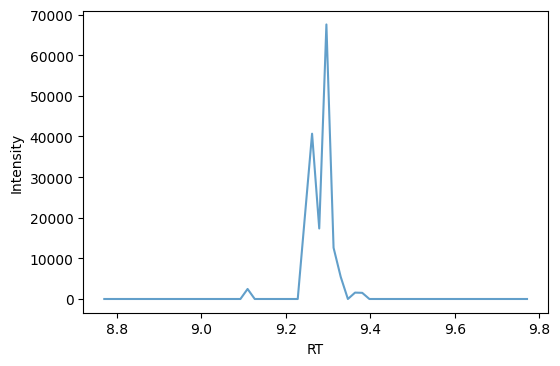

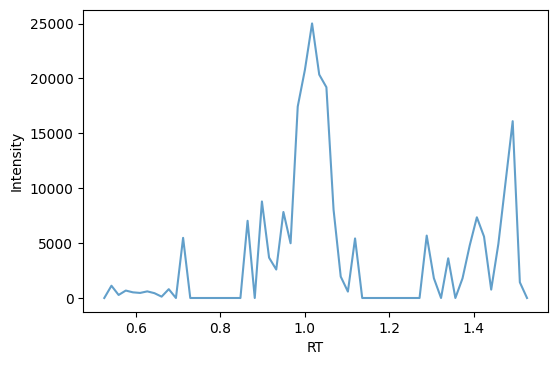

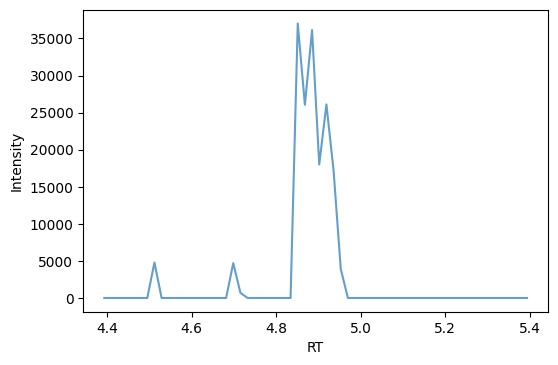

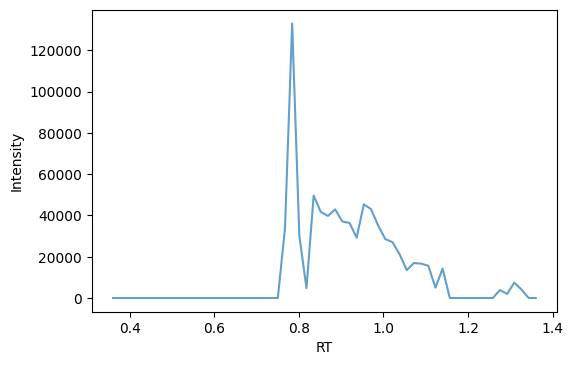

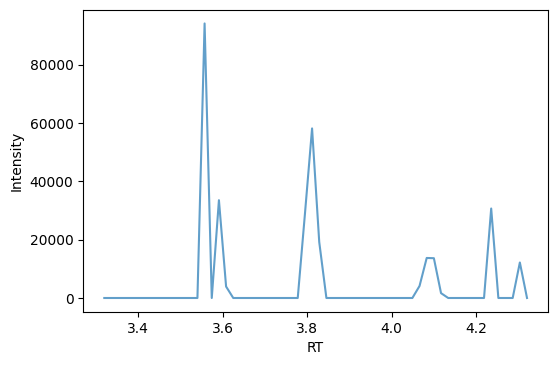

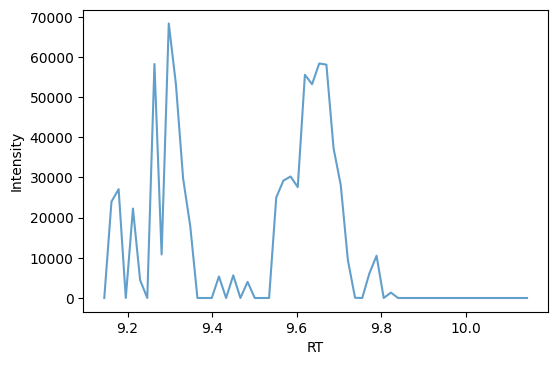

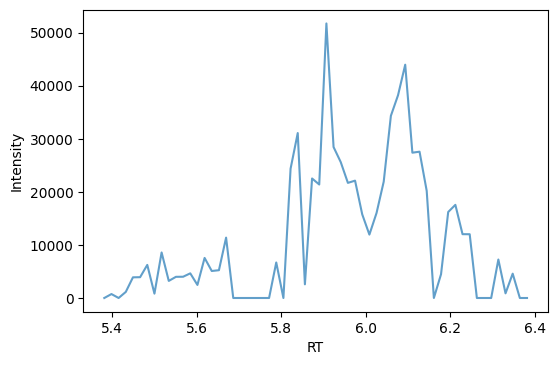

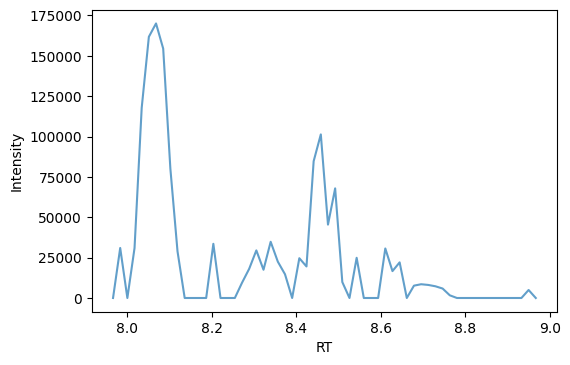

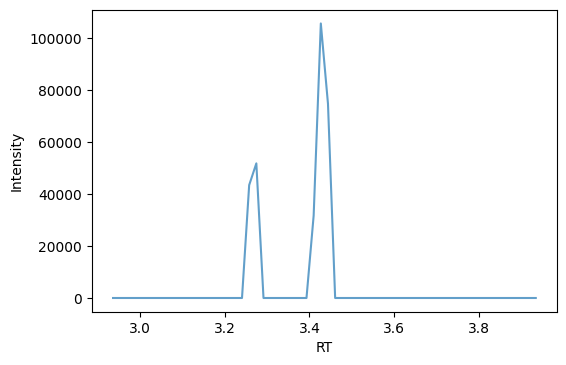

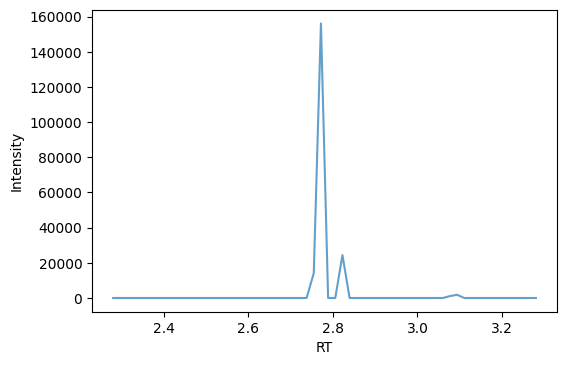

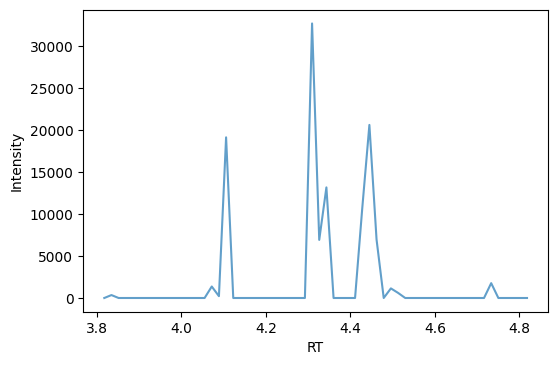

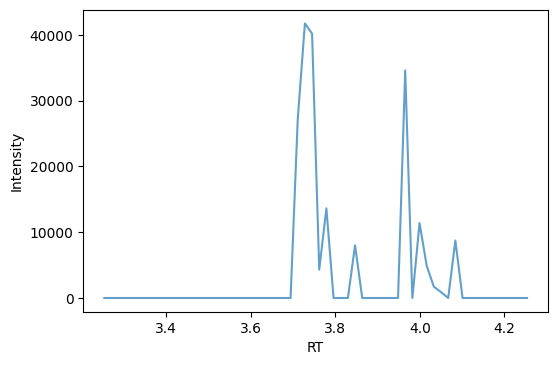

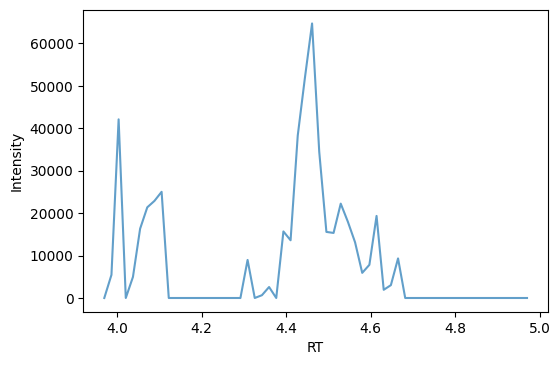

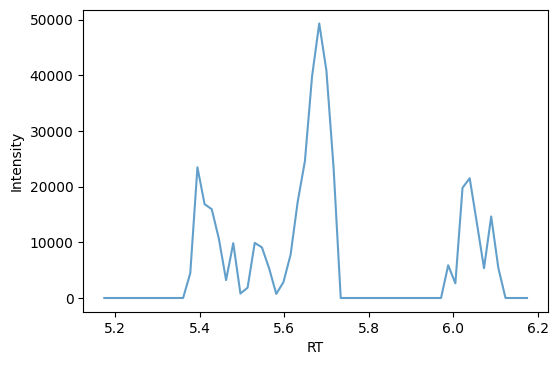

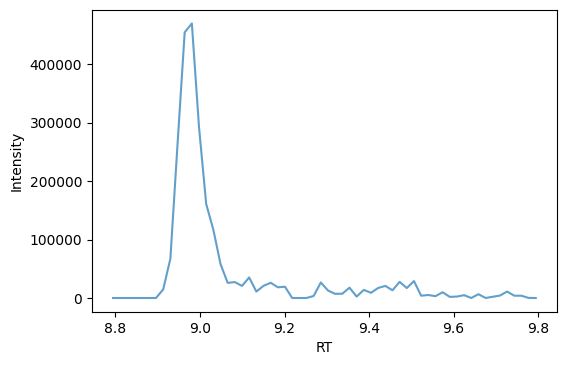

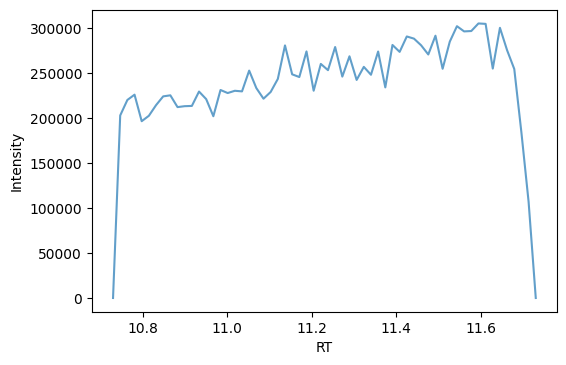

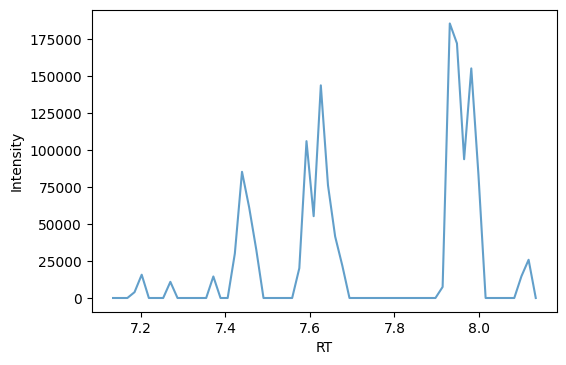

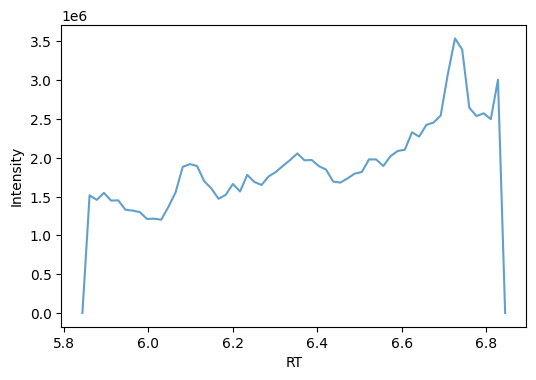

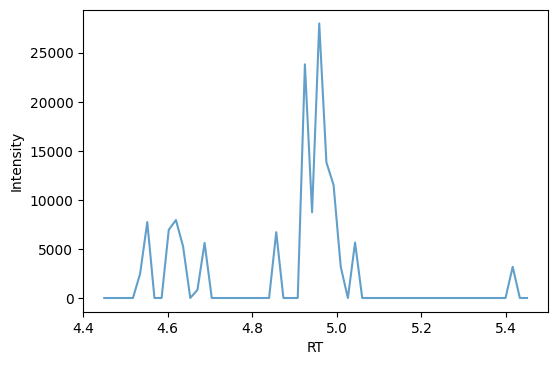

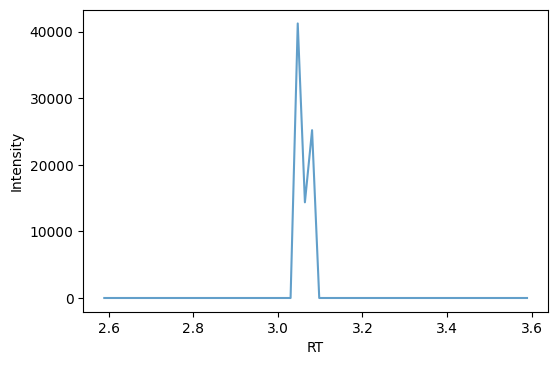

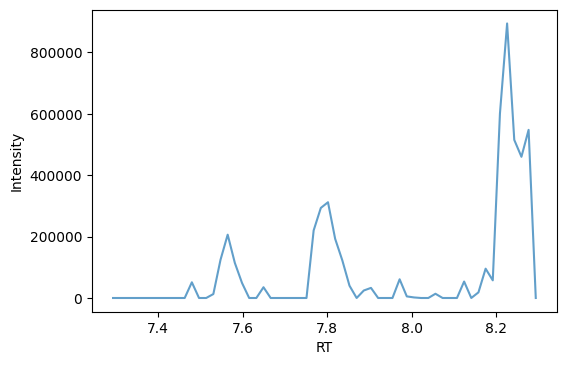

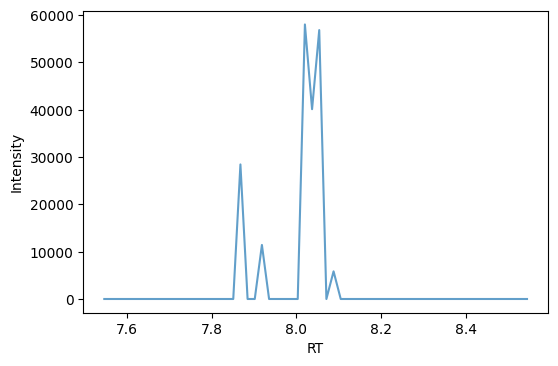

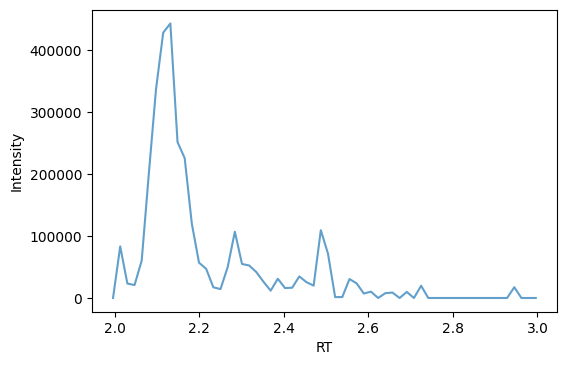

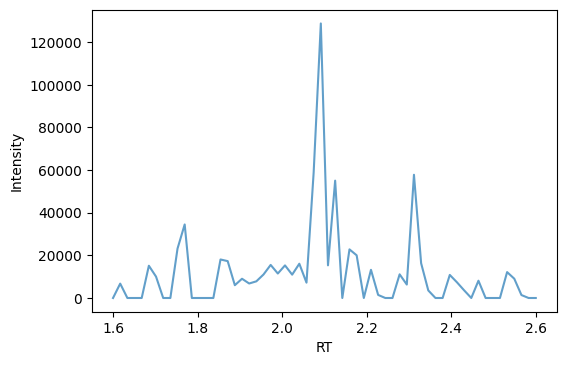

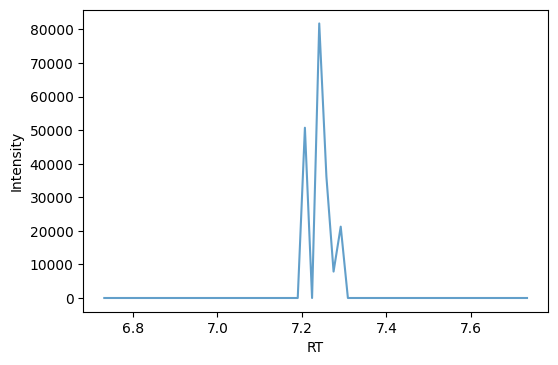

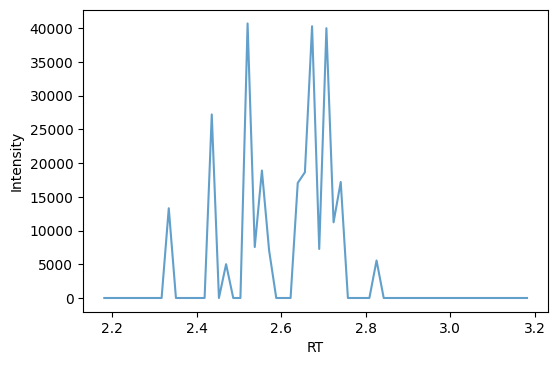

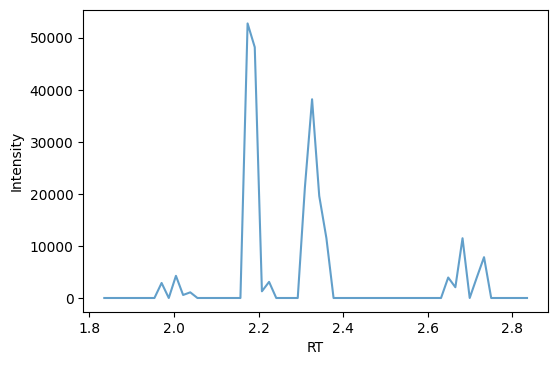

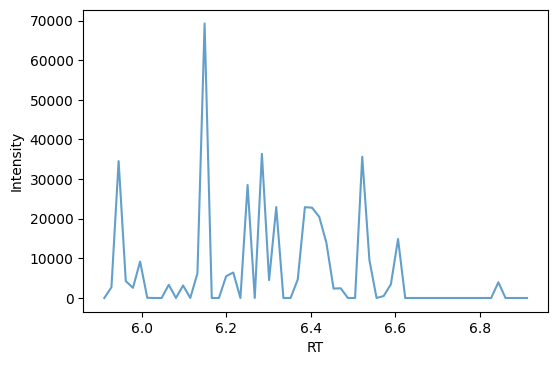

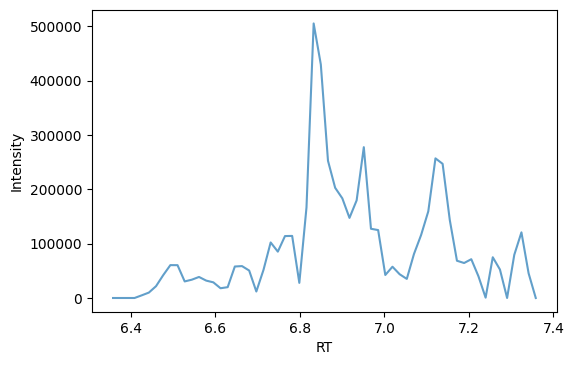

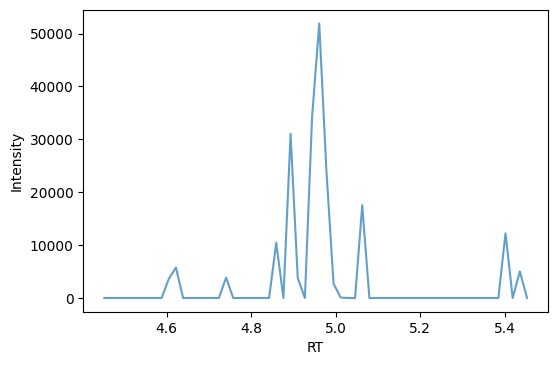

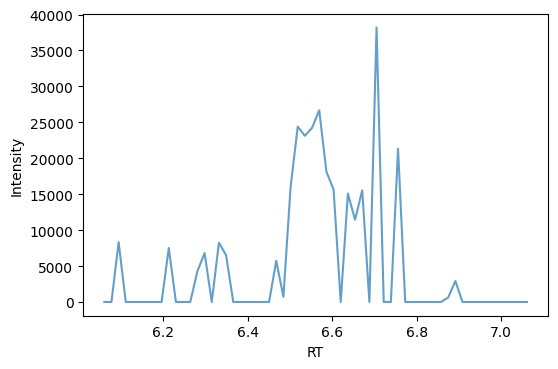

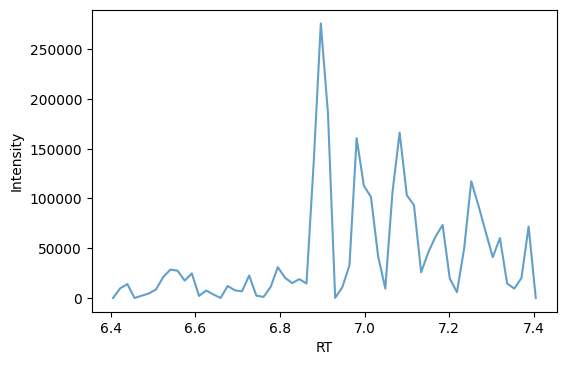

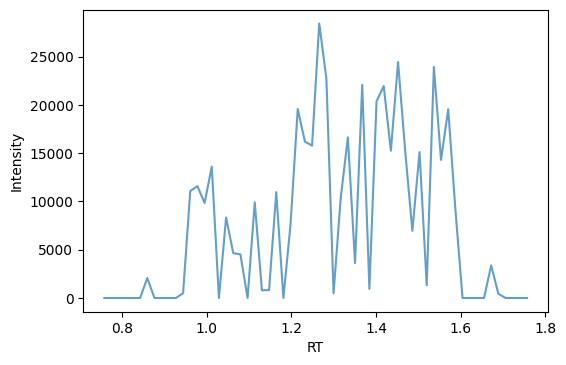

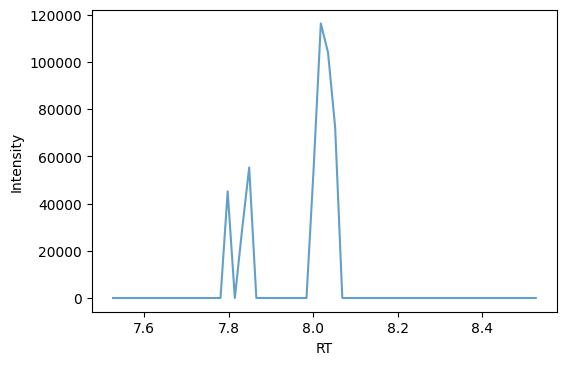

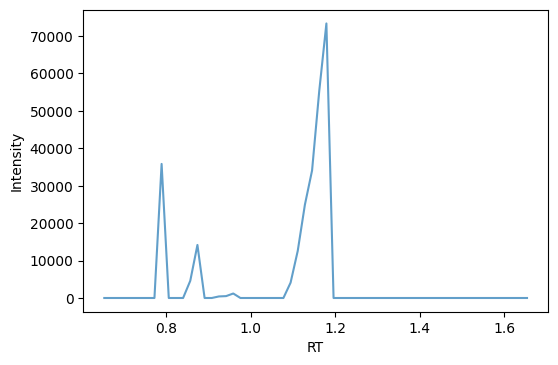

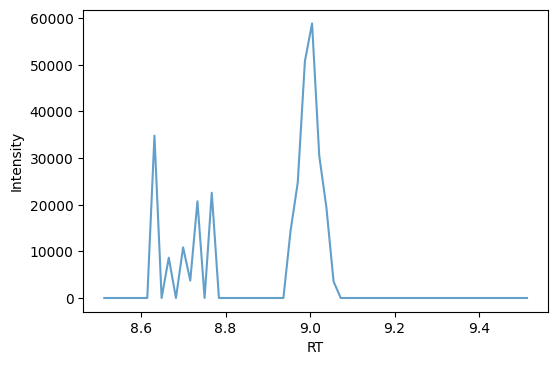

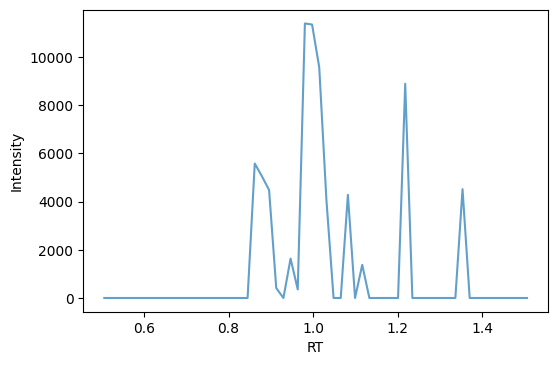

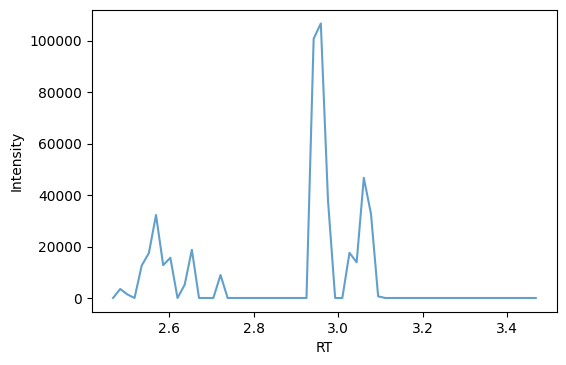

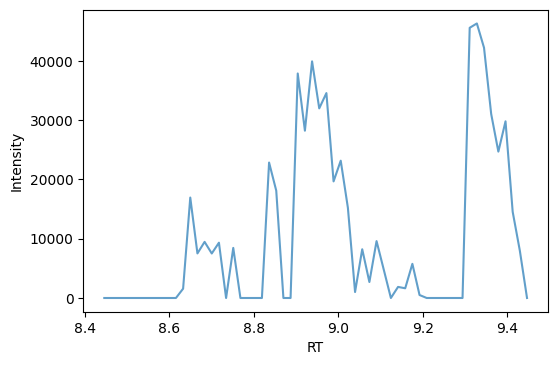

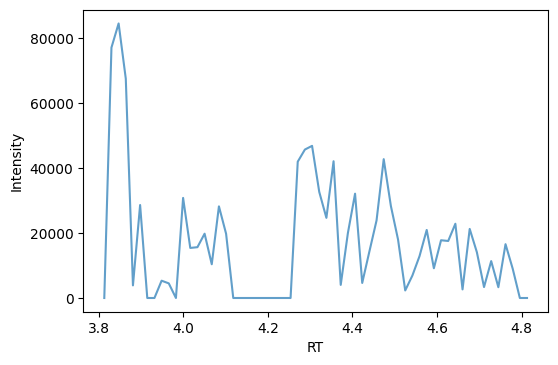

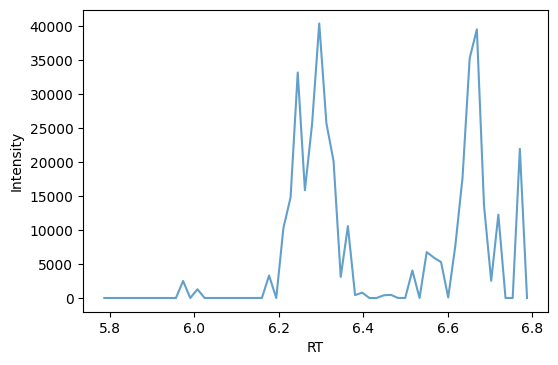

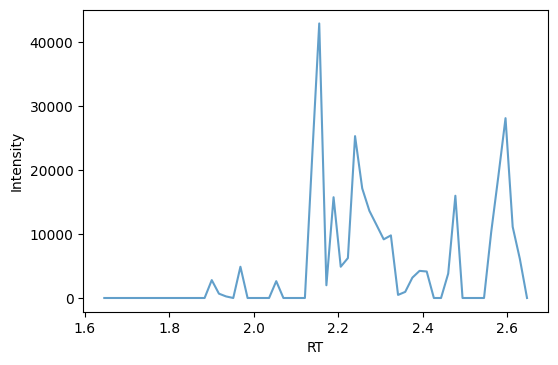

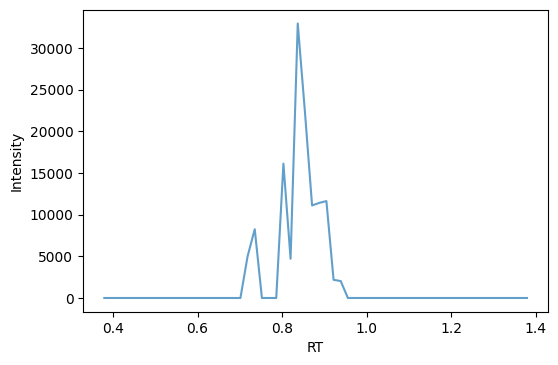

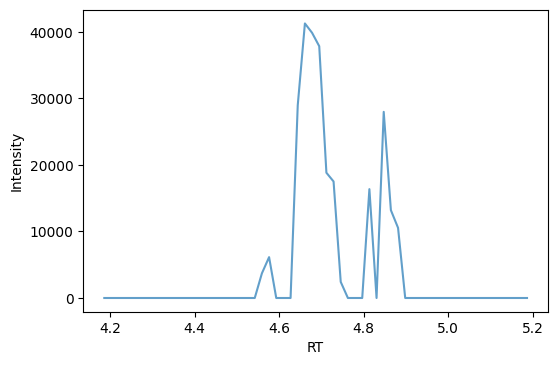

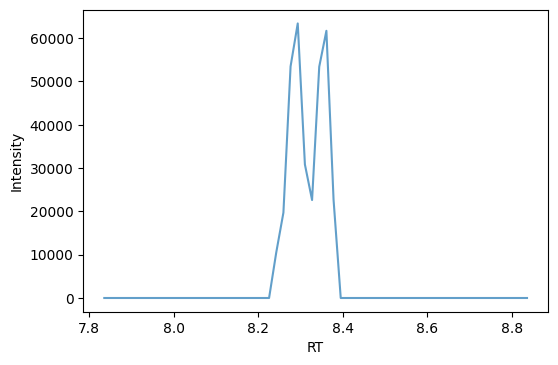

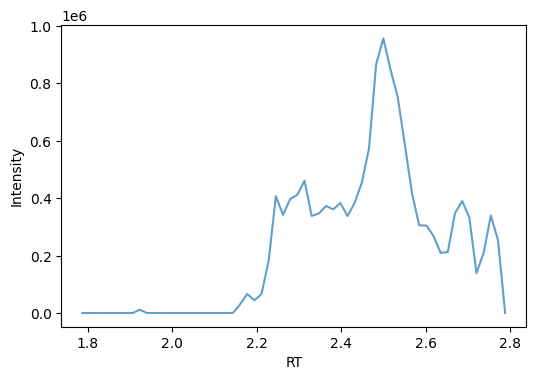

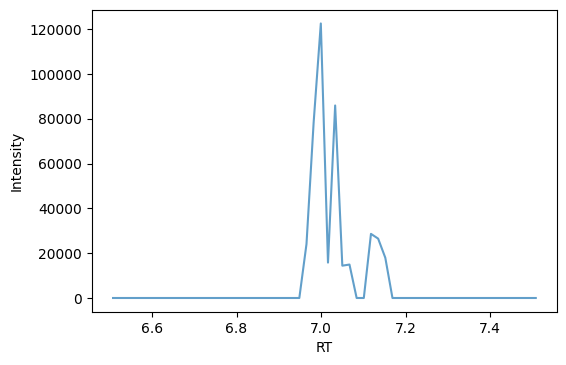

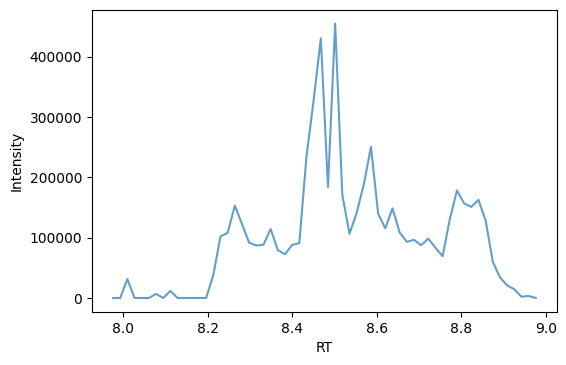

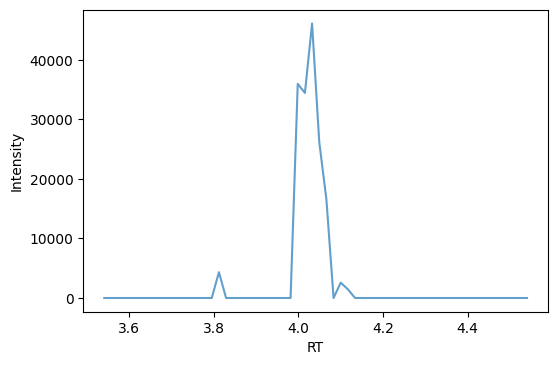

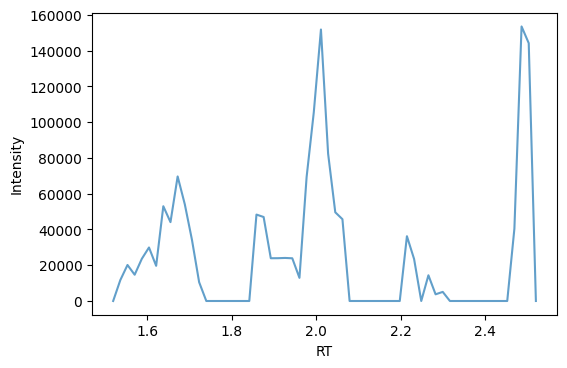

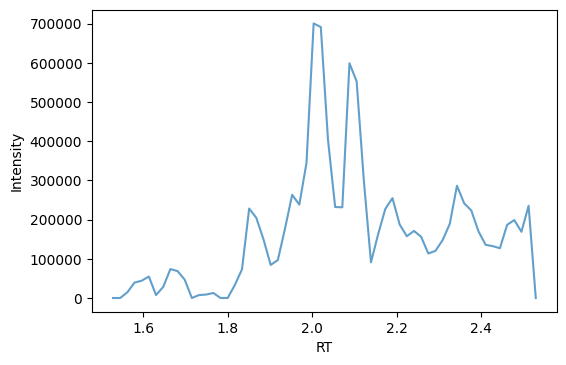

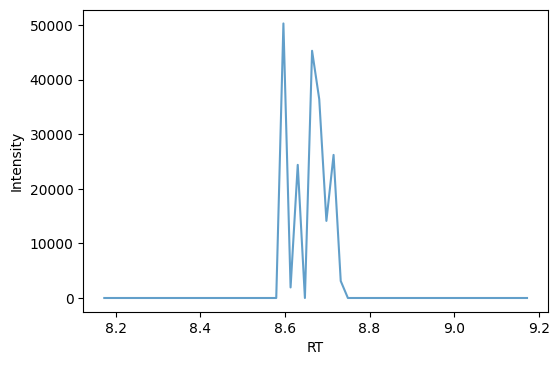

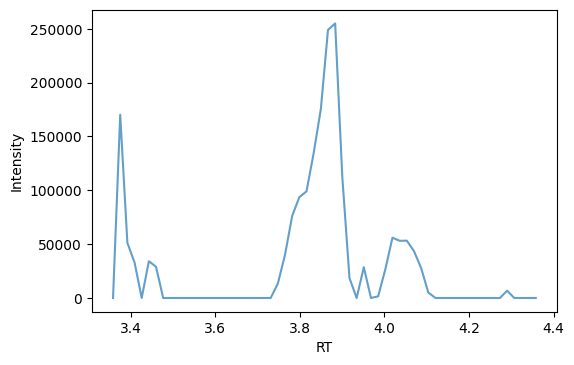

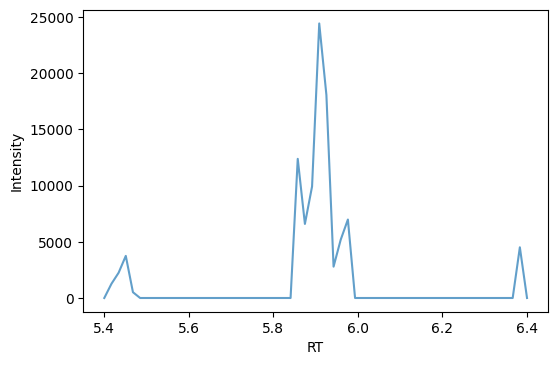

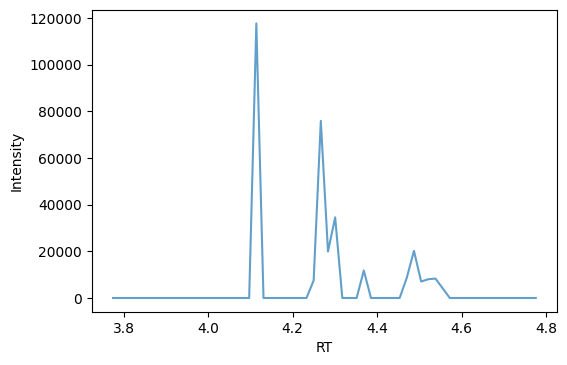

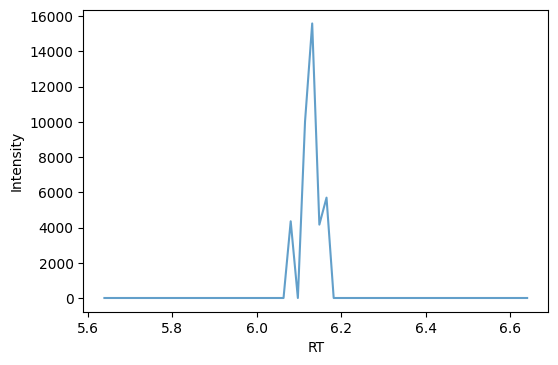

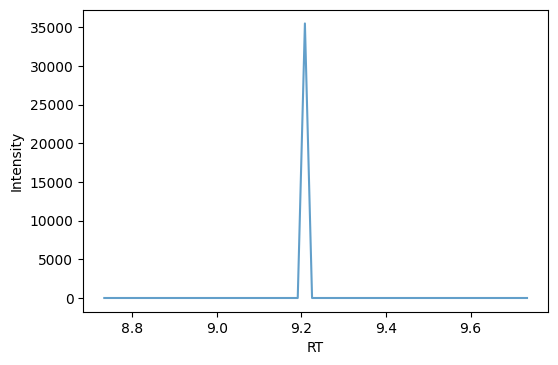

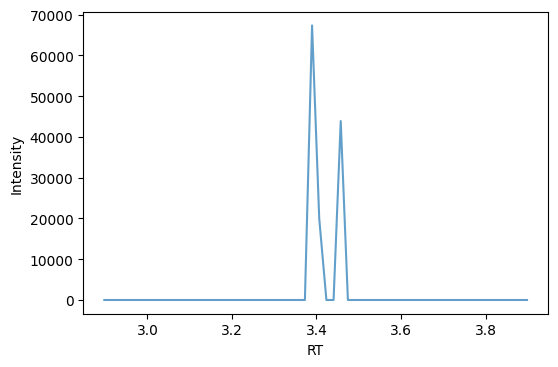

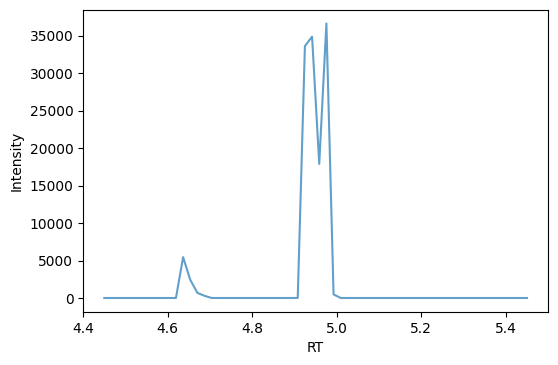

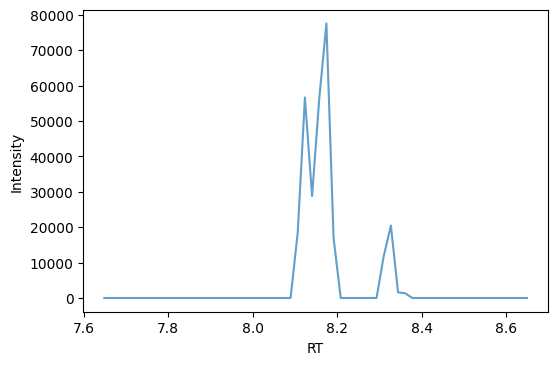

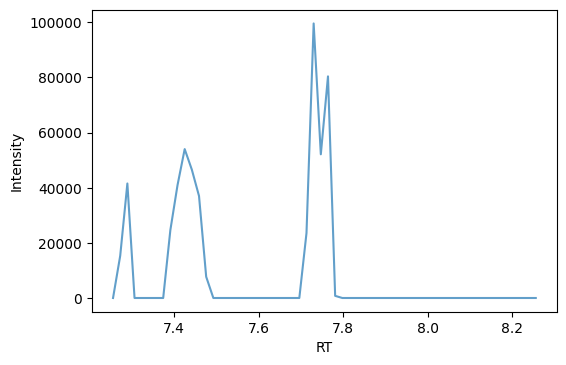

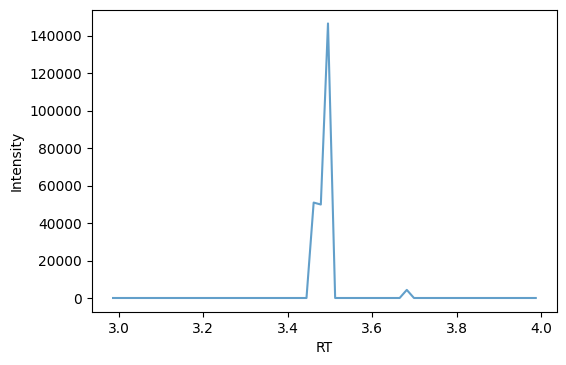

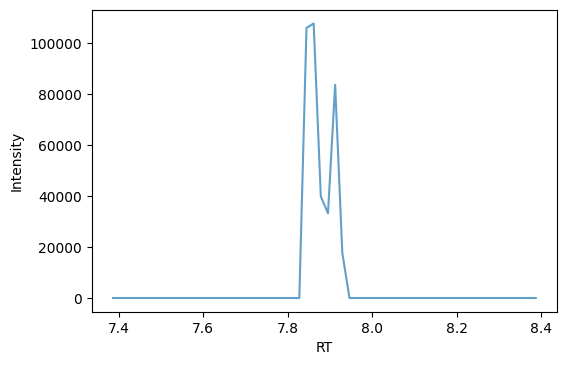

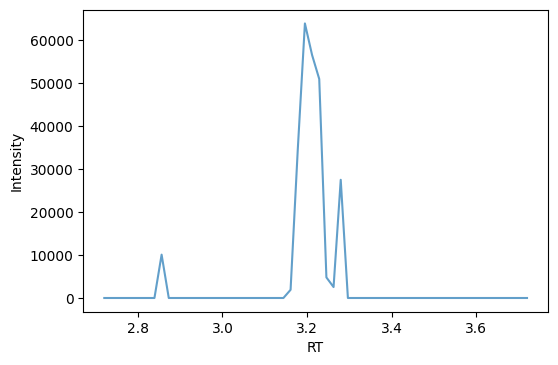

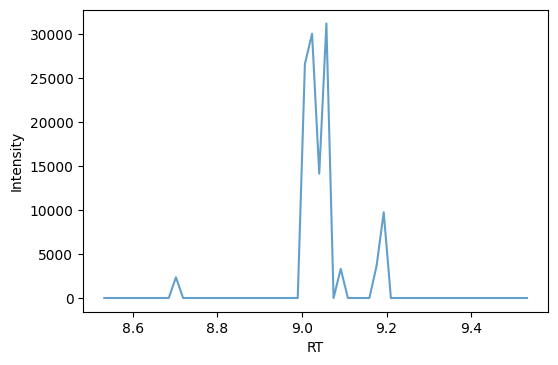

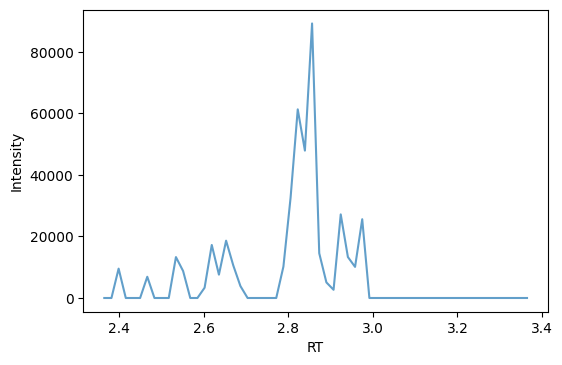

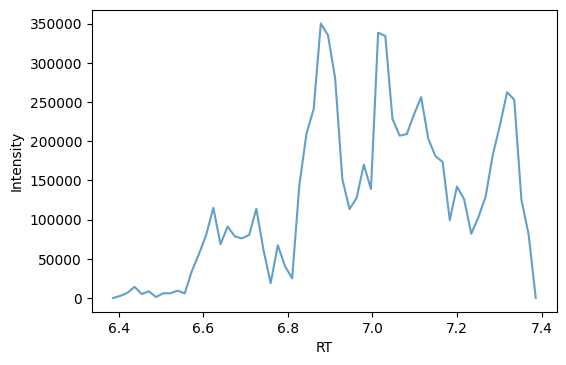

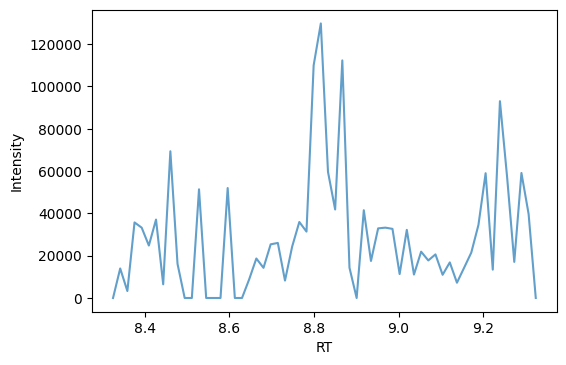

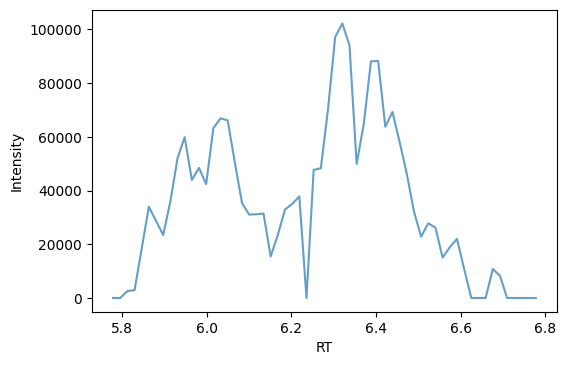

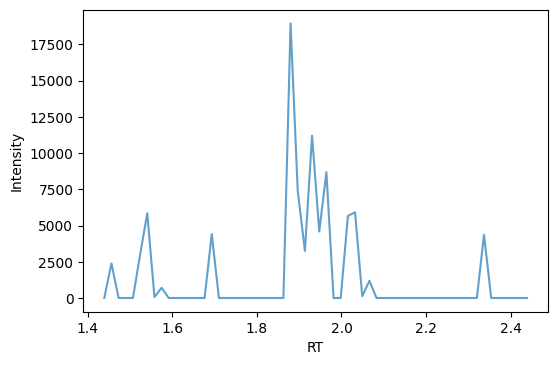

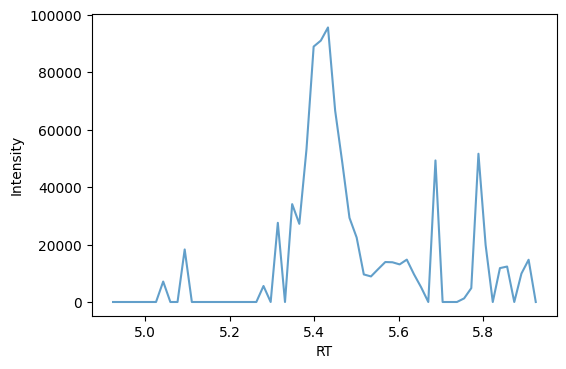

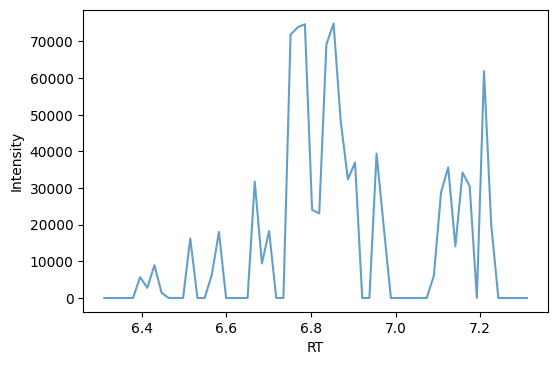

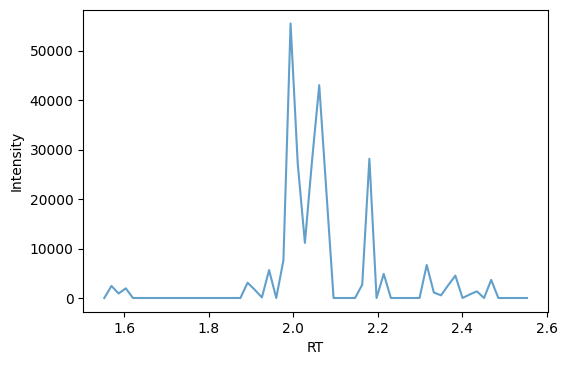

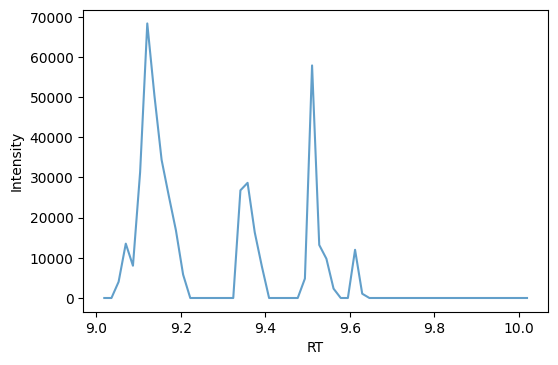

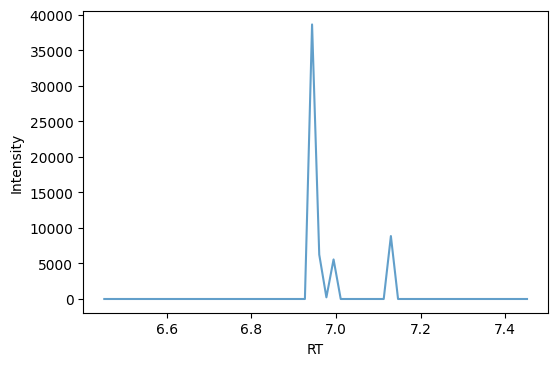

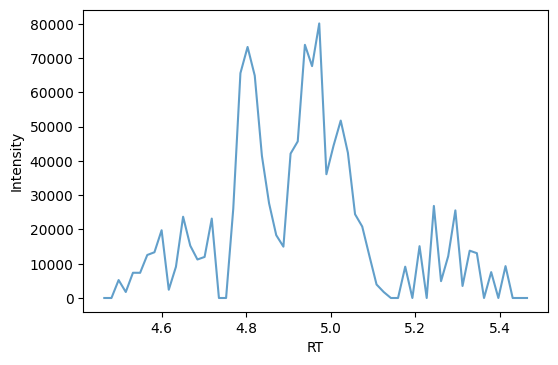

<Figure size 600x400 with 0 Axes>

In [200]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


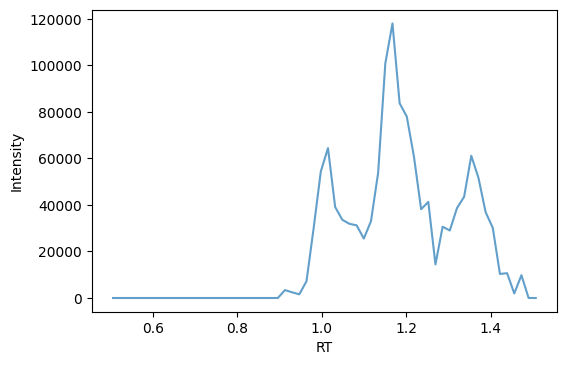

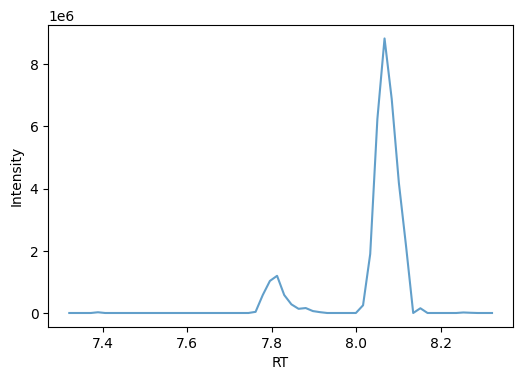

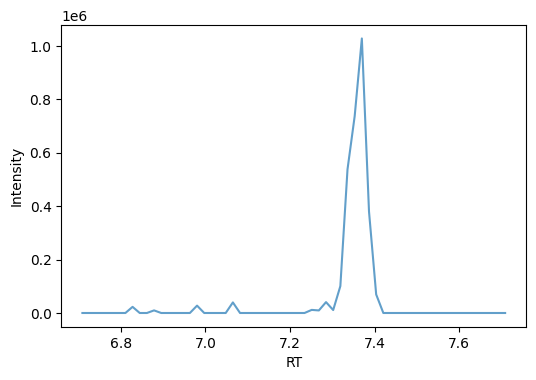

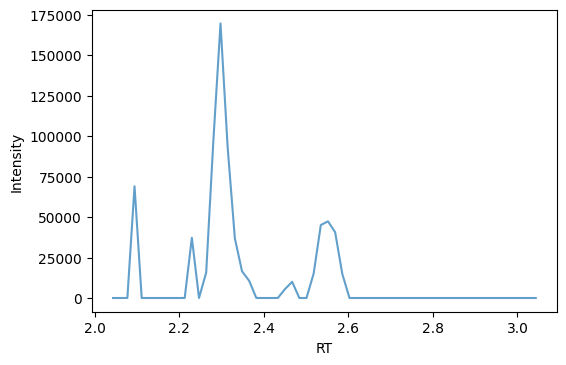

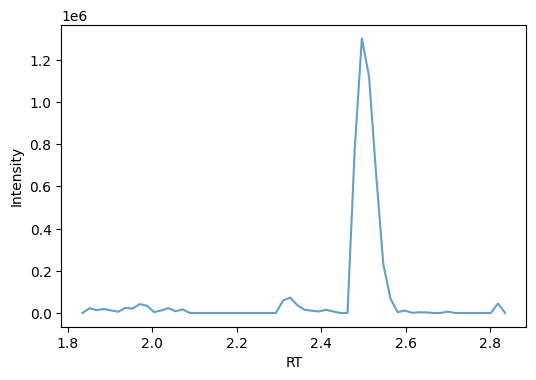

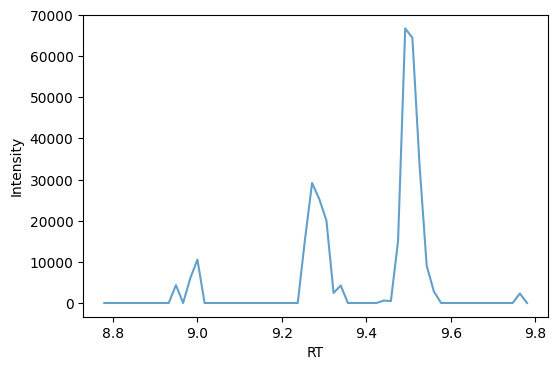

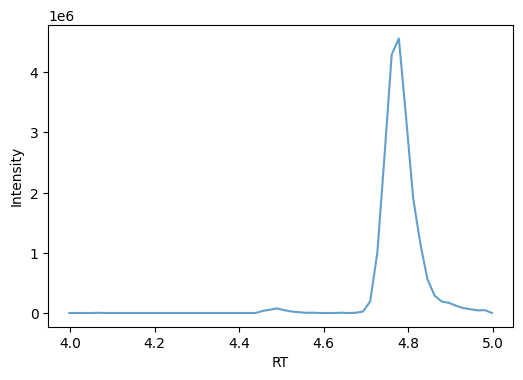

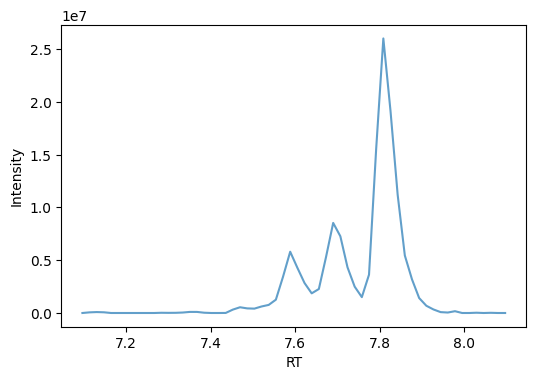

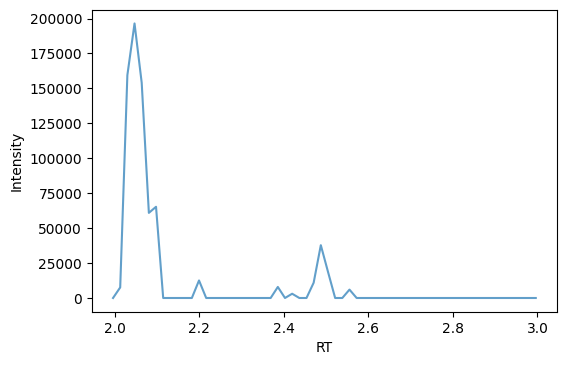

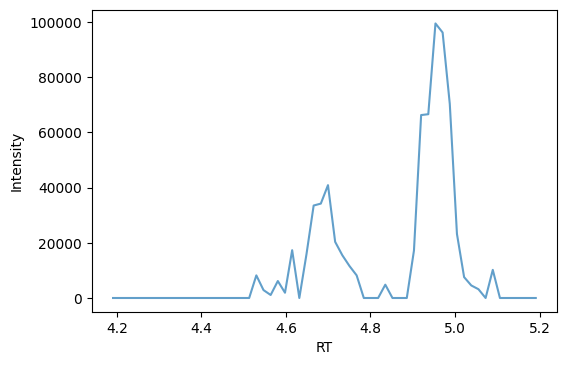

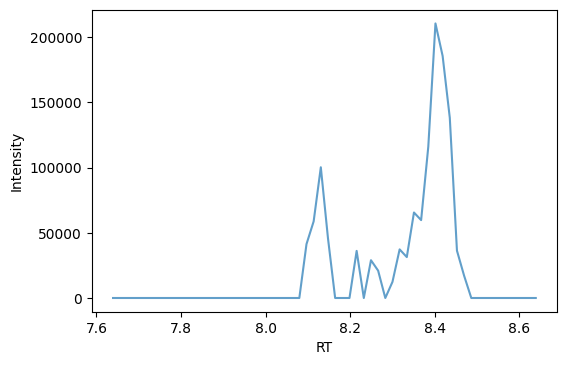

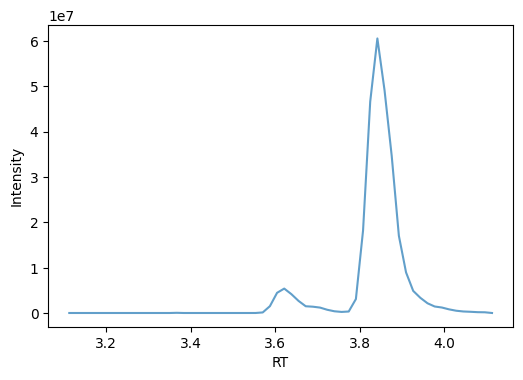

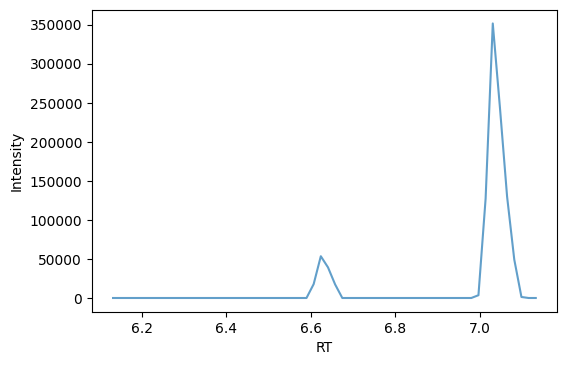

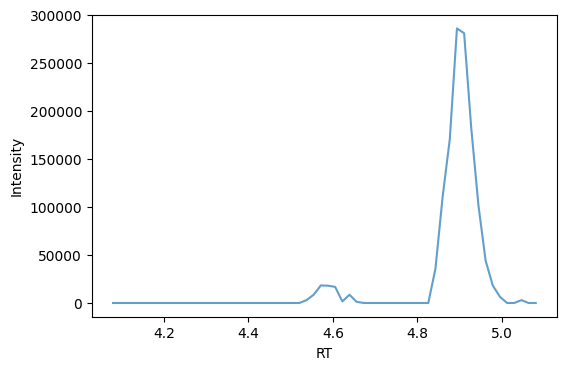

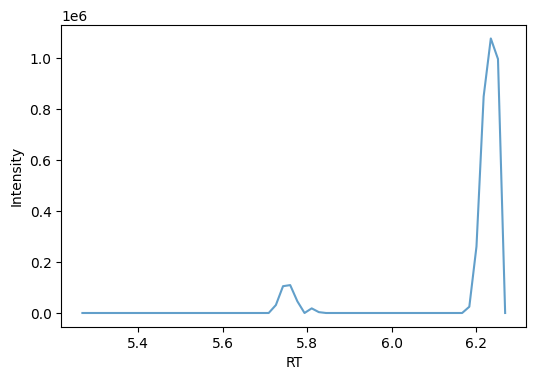

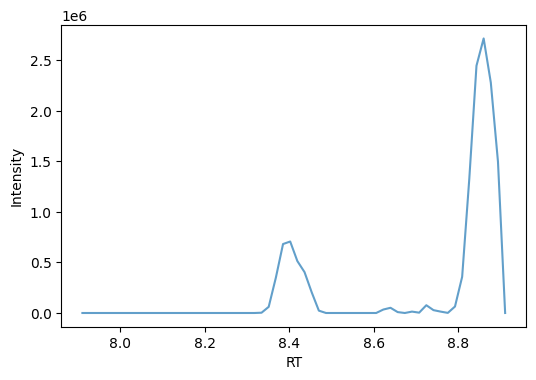

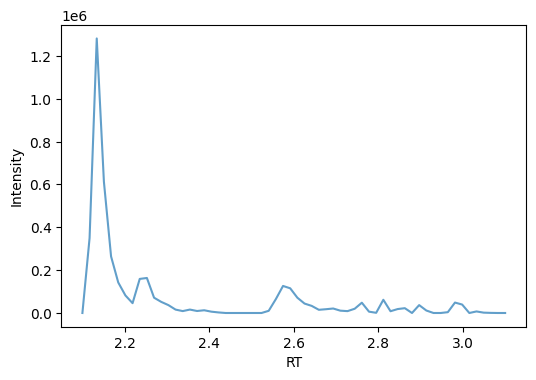

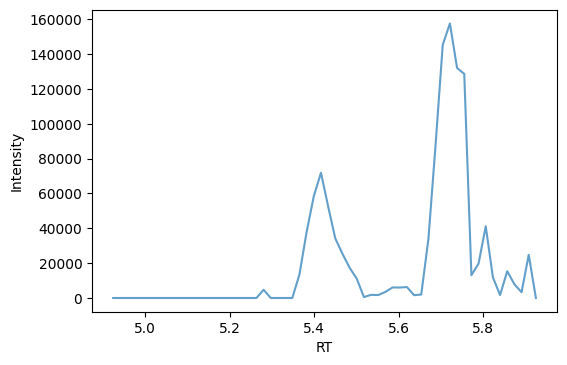

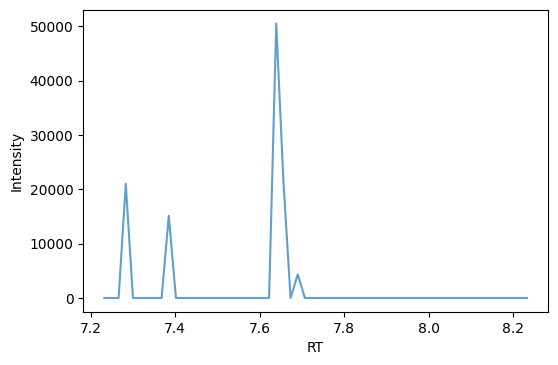

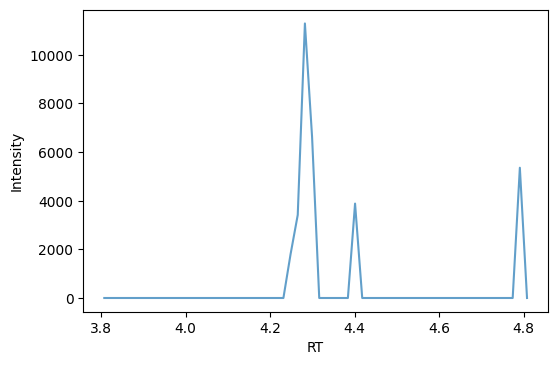

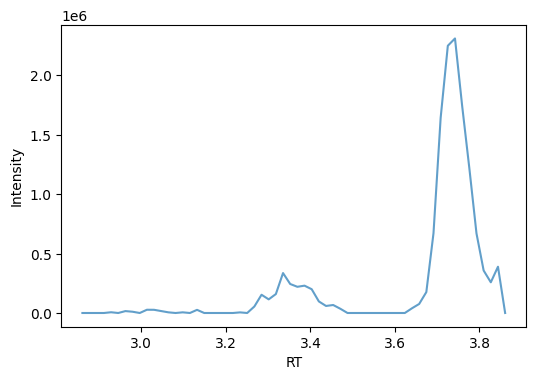

<Figure size 600x400 with 0 Axes>

In [201]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

In [202]:
xcmsCols = [x for x in peakList.columns.values if ".mzML" in x]
xcms_peak_areas = peakList[xcmsCols]
xcms_peak_areas

QC_01.mzML    QC_02.mzML    QC_03.mzML    QC_04.mzML    QC_05.mzML  \
FT00001  1.974936e+06  1.858493e+06  1.798871e+06  1.757297e+06  1.773365e+06   
FT00002  2.826669e+07  2.815197e+07  2.841696e+07  2.881003e+07  3.145220e+07   
FT00003  8.213799e+06  9.725321e+06  9.307397e+06  7.713435e+06  8.139520e+06   
FT00004  3.205281e+05  3.206047e+05  2.857381e+05  3.124773e+05  3.306725e+05   
FT00005  2.072345e+05  1.836083e+05  2.224421e+05  1.704847e+05  2.148285e+05   
...               ...           ...           ...           ...           ...   
FT32177  1.895676e+04  0.000000e+00  1.190416e+05  1.293768e+04  7.919847e+04   
FT32178  7.459506e+04  1.379095e+05  1.272461e+05  1.030717e+05  1.344736e+05   
FT32179  1.857563e+05  1.975252e+05  2.361436e+05  2.210434e+05  2.238891e+05   
FT32180  1.741973e+05  1.996532e+05  1.700717e+05  1.492381e+05  2.215041e+05   
FT32181  1.102636e+05  4.369822e+04  1.171374e+05  1.096281e+05  7.411829e+04   

           QC_06.mzML    QC_07.mzML  
FT00001  1.768485e+06  2.304243e+06  
FT00002  3.074870e+07  3.318160e+07  
FT00003  7.220048e+06  8.205855e+06  
FT00004  3.484202e+05  3.416744e+05  
FT00005  1.860289e+05  2.334494e+05  
...               ...           ...  
FT32177  0.000000e+00  2.039624e+05  
FT32178  1.053646e+05  7.916662e+04  
FT32179  2.395129e+05  2.108537e+05  
FT32180  1.772771e+05  2.104139e+05  
FT32181  1.437213e+05  1.249721e+05  

[32181 rows x 7 columns]

In [203]:
pdCols = [x for x in peak_intensities.columns.values if ".mzML" in x and "D:" in x]
pd_peak_areas = peak_intensities[pdCols]
pd_peak_areas

D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_01.mzML  \
FT00001                                       1.769880e+06          
FT00002                                       2.521567e+07          
FT00003                                       4.741310e+06          
FT00004                                       3.247647e+05          
FT00005                                       1.270711e+05          
...                                                    ...          
FT32177                                       0.000000e+00          
FT32178                                       5.756685e+04          
FT32179                                       2.167130e+05          
FT32180                                       1.806937e+05          
FT32181                                       9.584854e+04          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_02.mzML  \
FT00001                                       1.995128e+06          
FT00002                                       2.381203e+07          
FT00003                                       4.900700e+06          
FT00004                                       2.627235e+05          
FT00005                                       1.359119e+05          
...                                                    ...          
FT32177                                       4.771996e+04          
FT32178                                       1.539369e+05          
FT32179                                       2.048464e+05          
FT32180                                       1.884061e+05          
FT32181                                       7.624763e+04          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_03.mzML  \
FT00001                                       1.656394e+06          
FT00002                                       2.534021e+07          
FT00003                                       4.344961e+06          
FT00004                                       2.389141e+05          
FT00005                                       1.763679e+05          
...                                                    ...          
FT32177                                       6.576219e+04          
FT32178                                       1.386527e+05          
FT32179                                       2.162318e+05          
FT32180                                       1.799968e+05          
FT32181                                       1.129991e+05          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_04.mzML  \
FT00001                                       1.704545e+06          
FT00002                                       2.639797e+07          
FT00003                                       3.889854e+06          
FT00004                                       3.570118e+05          
FT00005                                       1.278125e+05          
...                                                    ...          
FT32177                                       1.243104e+04          
FT32178                                       5.975270e+04          
FT32179                                       2.144428e+05          
FT32180                                       1.416792e+05          
FT32181                                       1.071433e+05          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_05.mzML  \
FT00001                                       1.655782e+06          
FT00002                                       2.793932e+07          
FT00003                                       4.951160e+06          
FT00004                                       3.002346e+05          
FT00005                                       1.415793e+05          
...                                                    ...          
FT32177                                       3.855859e+04          
FT32178                                       1.567947e+05          
FT32179                                       2.058378e+05          
FT3

0.5096795567266228


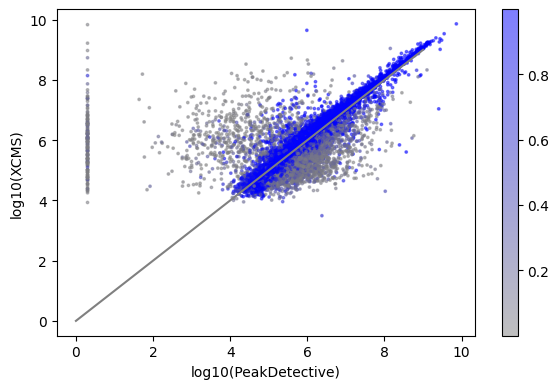

In [204]:
plt.scatter(np.log10(pd_peak_areas.values.mean(axis=1)+2),np.log10(xcms_peak_areas.values.mean(axis=1)),s=3,alpha=0.5,c=peak_scores[pdCols].values.mean(axis=1),cmap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
)
plt.plot([0,9],[0,9],color="grey")
plt.xlabel("log10(PeakDetective)")
plt.ylabel("log10(XCMS)")
cbar = plt.colorbar()
print(met.r2_score(pd_peak_areas.values.mean(axis=1),xcms_peak_areas.values.mean(axis=1)))
plt.tight_layout()
plt.savefig(datadir + "intensity_scatter.png",dpi=300)